# Recipe Site Traffic
<a href="https://fawzyalmatary.com/" style="font-size:16px; color:blue; text-decoration:none;">Fawzy Almatary</a>

- **For the presentation that summarizes the finding and recommenadtions of this analysis,  [Click Here](https://github.com/Fawzy-Almatary/Portfolio-Projects/blob/main/Recipe-Site-Traffic-Project/Presentation__recipe_site_traffic.pdf).**


## Table of Contents

1. <a href="#background">Background</a></li>
2. <a href="#validation">Data Validation</a></li>
3. <a href="#eda">Exploratory Analysis</a></li>
4. <a href="#development">Model Development</a></li>
5. <a href="#evaluation">Model Evaluation</a></li>
6. <a href="#business">Business Metrics</a></li>
7. <a href="#recommendations">Recommendations</a></li>

<a id='background'></a>
# 1. Background:
- Tasty Bites is a subscription-based meal planning and ingredient delivery service that provides healthy and balanced meals to customers, regardless of their budget.


- The Product Manager of Tasty Bytes wants us to predict which recipes will be popular and lead to high traffic of the website 80% of the time and minimize the chance of showing unpopular recipes.


- Increase website traffic will boost subscriptions, which will drive higher profits.

<a id='validation'></a>
# 2. Data Validation

In [1]:
# Import the packages that will be needed in data validation and exploratory analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import the packages that will be needed in model development and evaluation
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Ensure thar warning messages are suppressed
import warnings
warnings.filterwarnings('ignore')

# Define seed for the notebook to ensure reproducibility
# Seed was chosen according to the date of doing this project (3rd of July, 2023)
seed = 20230703
np.random.seed(seed)

# Define setting for the plots in this notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Load the dataset from a csv file into a dataframe
path = 'Dataset__recipe_site_traffic.csv'
df = pd.read_csv(path)
df.sample(10)

recipe  calories  carbohydrate  sugar  protein       category servings  \
582     583    451.79         19.64   4.16     5.37      Vegetable        6   
748     749    227.88         21.19  15.05    83.90           Pork        4   
859     860       NaN           NaN    NaN      NaN  One Dish Meal        4   
200     201     89.72         10.83   2.26     4.52      Vegetable        2   
868     869    301.49         10.39  14.02     4.94   Lunch/Snacks        4   
56       57     47.17         60.93  13.82    10.80      Vegetable        4   
710     711    207.57          1.52   4.46    15.05  One Dish Meal        6   
300     301     84.27          5.07   8.97     0.38      Beverages        1   
289     290    223.01         25.99   7.52    11.69           Meat        4   
772     773       NaN           NaN    NaN      NaN  One Dish Meal        4   

    high_traffic  
582         High  
748          NaN  
859          NaN  
200         High  
868         High  
56          High  
710         High  
300          NaN  
289         High  
772          NaN

- First, we will check for any missing values in the dataset and try to understand it to further decide how to deal with it.

In [3]:
df.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

- The missing data in the "high_traffic" column can be interpreted as Low traffic recipes.
- However, there is an interesting observation in the dataset. Four columns have identical values of 52 missing values.
- This suggests that these rows might be missing values for all four columns. To validate this assumption, further investigation is required.

In [4]:
df[df.columns[~df.columns.isin(['high_traffic'])]].isnull().any(axis=1).sum()

52

- After excluding "high_traffic" column, number of rows that contains __any__ missing value is also 52 rows. This confirms that the rows missing values in the four columns are indeed the same rows.

- Next, let's check the column types:

In [5]:
df.dtypes

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

- Now, we will take a general view of each column of the data to get a better understanding for it.

In [6]:
def col_lists(dataframe):
    return dataframe.select_dtypes(exclude='object').columns.tolist(), dataframe.select_dtypes(include='object').columns.tolist()

def inspect_df(dataframe):
    num_cols, obj_cols = col_lists(df)
    print(" Shape ".center(50, '#'), end='\n\n')
    print(f"This dataframe consists of {dataframe.shape[0]} rows and {dataframe.shape[1]} columns.")
    print(f"Number of duplicated rows is {df.duplicated().sum()} rows.", end='\n\n\n')

    print(" Categorical Columns' Data ".center(50, '#'), end='\n\n')
    for col in obj_cols:
        print(f'"{col}" column:')
        print(f'='*(len(col)+10))
        print(f'"{col}" column has {dataframe[col].isnull().sum()} null values.')
        print(dataframe[col].value_counts(), end='\n\n\n')
    
    print(" Numerical Columns' Statistics ".center(50, '#'), end='\n\n')
    print(df.describe().T.round(2))

inspect_df(df)

##################### Shape ######################

This dataframe consists of 947 rows and 8 columns.
Number of duplicated rows is 0 rows.


########### Categorical Columns' Data ############

"category" column:
"category" column has 0 null values.
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64


"servings" column:
"servings" column has 0 null values.
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64


"high_traffic" column:
"high_traffic" column has 373 null values.
High    574
Name: high_traffic, dtype: int64


######### Numerical Columns' Statistics ##########

              count    mean     std   min     25%     50%     75%      max
recipe        947.0  474.00  2

#### Based on the previous analyses, several problems were identified and addressed:
1. The "recipe" column has been removed as it was found to be unnecessary for the analysis.
2. The "high_traffic" column originally had only one value, 'High'. To handle null values in this column, they have been replaced with 'Low' to provide a more accurate representation.
3. The "servings" column had two extra values ('4 as a snack' and '6 as a snack'). These values have been corrected to numeric values (4 and 6), and the column type has been changed to integer instead of object.
4. The "category" column originally had 11 values instead of 10. Upon investigation, it was discovered that some recipes were categorized as 'Chicken Breast' instead of 'Chicken'. To ensure consistency, these categories have been merged into a single category called 'Chicken'.
5. There were 52 rows with 4 missing values each. To handle these missing values, it was decided to simply remove the rows, as they would not significantly impact the analysis.

- By implementing these improvements, the dataset has been refined and is now better prepared for further analysis.

In [7]:
df.drop('recipe', axis=1, inplace=True)
df.high_traffic = df.high_traffic.fillna('Low')
df.servings = df.servings.replace({'6 as a snack':'6', '4 as a snack':'4'}).astype(int)
df.category = df.category.replace({'Chicken Breast':'Chicken'})
df.dropna(how='any', inplace=True)

<a id='eda'></a>
# 3. Exploratory Analysis

- Our primary objective is to minimize false positives, which refers to recipes that are predicted to have high traffic but actually have low traffic. Our aim is to achieve the highest possible precision in our predictions.

- Before proceeding with model development, it is crucial to have a clear understanding of the business precision. This can be determined by calculating the percentage of high traffic recipes out of all recipes. From the business perspective, all recipes were initially predicted to generate high traffic.

- Establishing this baseline will provide a benchmark for evaluating the performance of models that will be developed.


--> Business precision (percentage of high traffic recipes) is "59.78%".



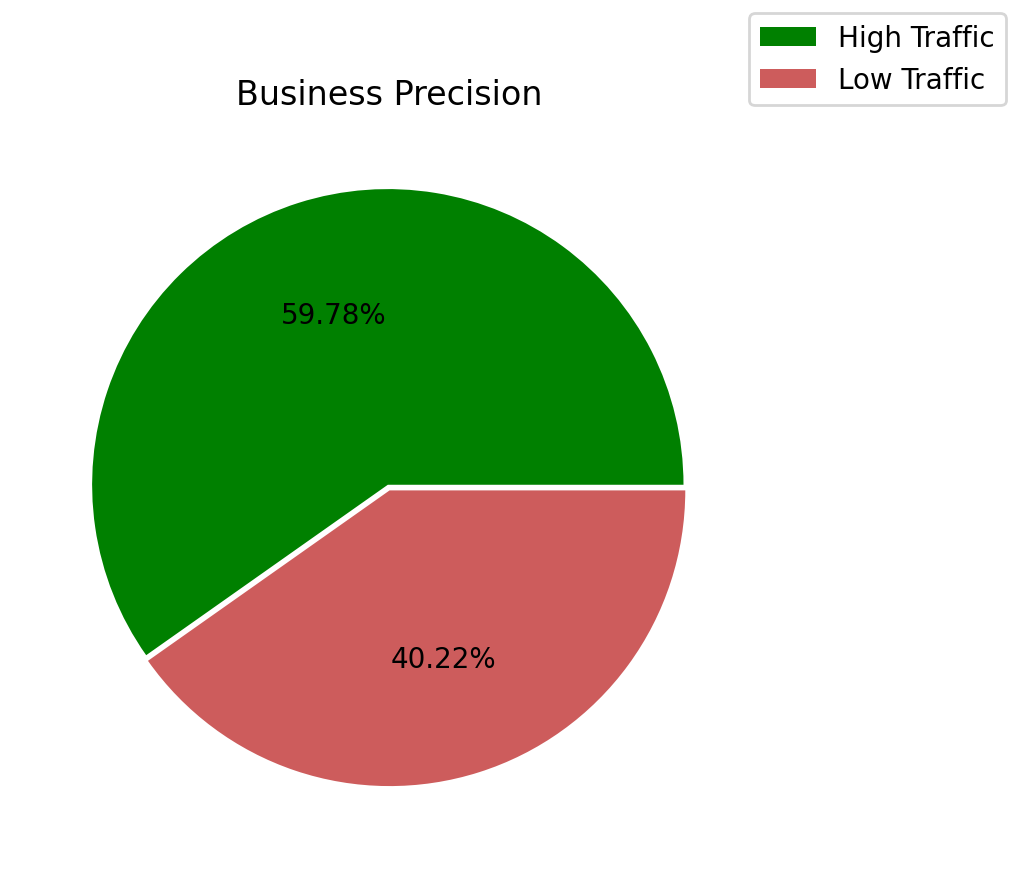

In [8]:
business_precision = df.high_traffic.value_counts(normalize=True)[0]

text = f'--> Business precision (percentage of high traffic recipes) is "{business_precision*100:.2f}%".'
print(f"\n{'='*len(text)}\n{text}\n{'='*len(text)}\n")

df.high_traffic.value_counts(normalize=True).apply(lambda r: r*100).plot(
    kind='pie', autopct='%.2f%%', explode=(0.02,0), colors=['green', 'indianred'], labels=None
    ).set(ylabel=None, title='Business Precision')
plt.figlegend(labels=['High Traffic', 'Low Traffic'])
plt.show()

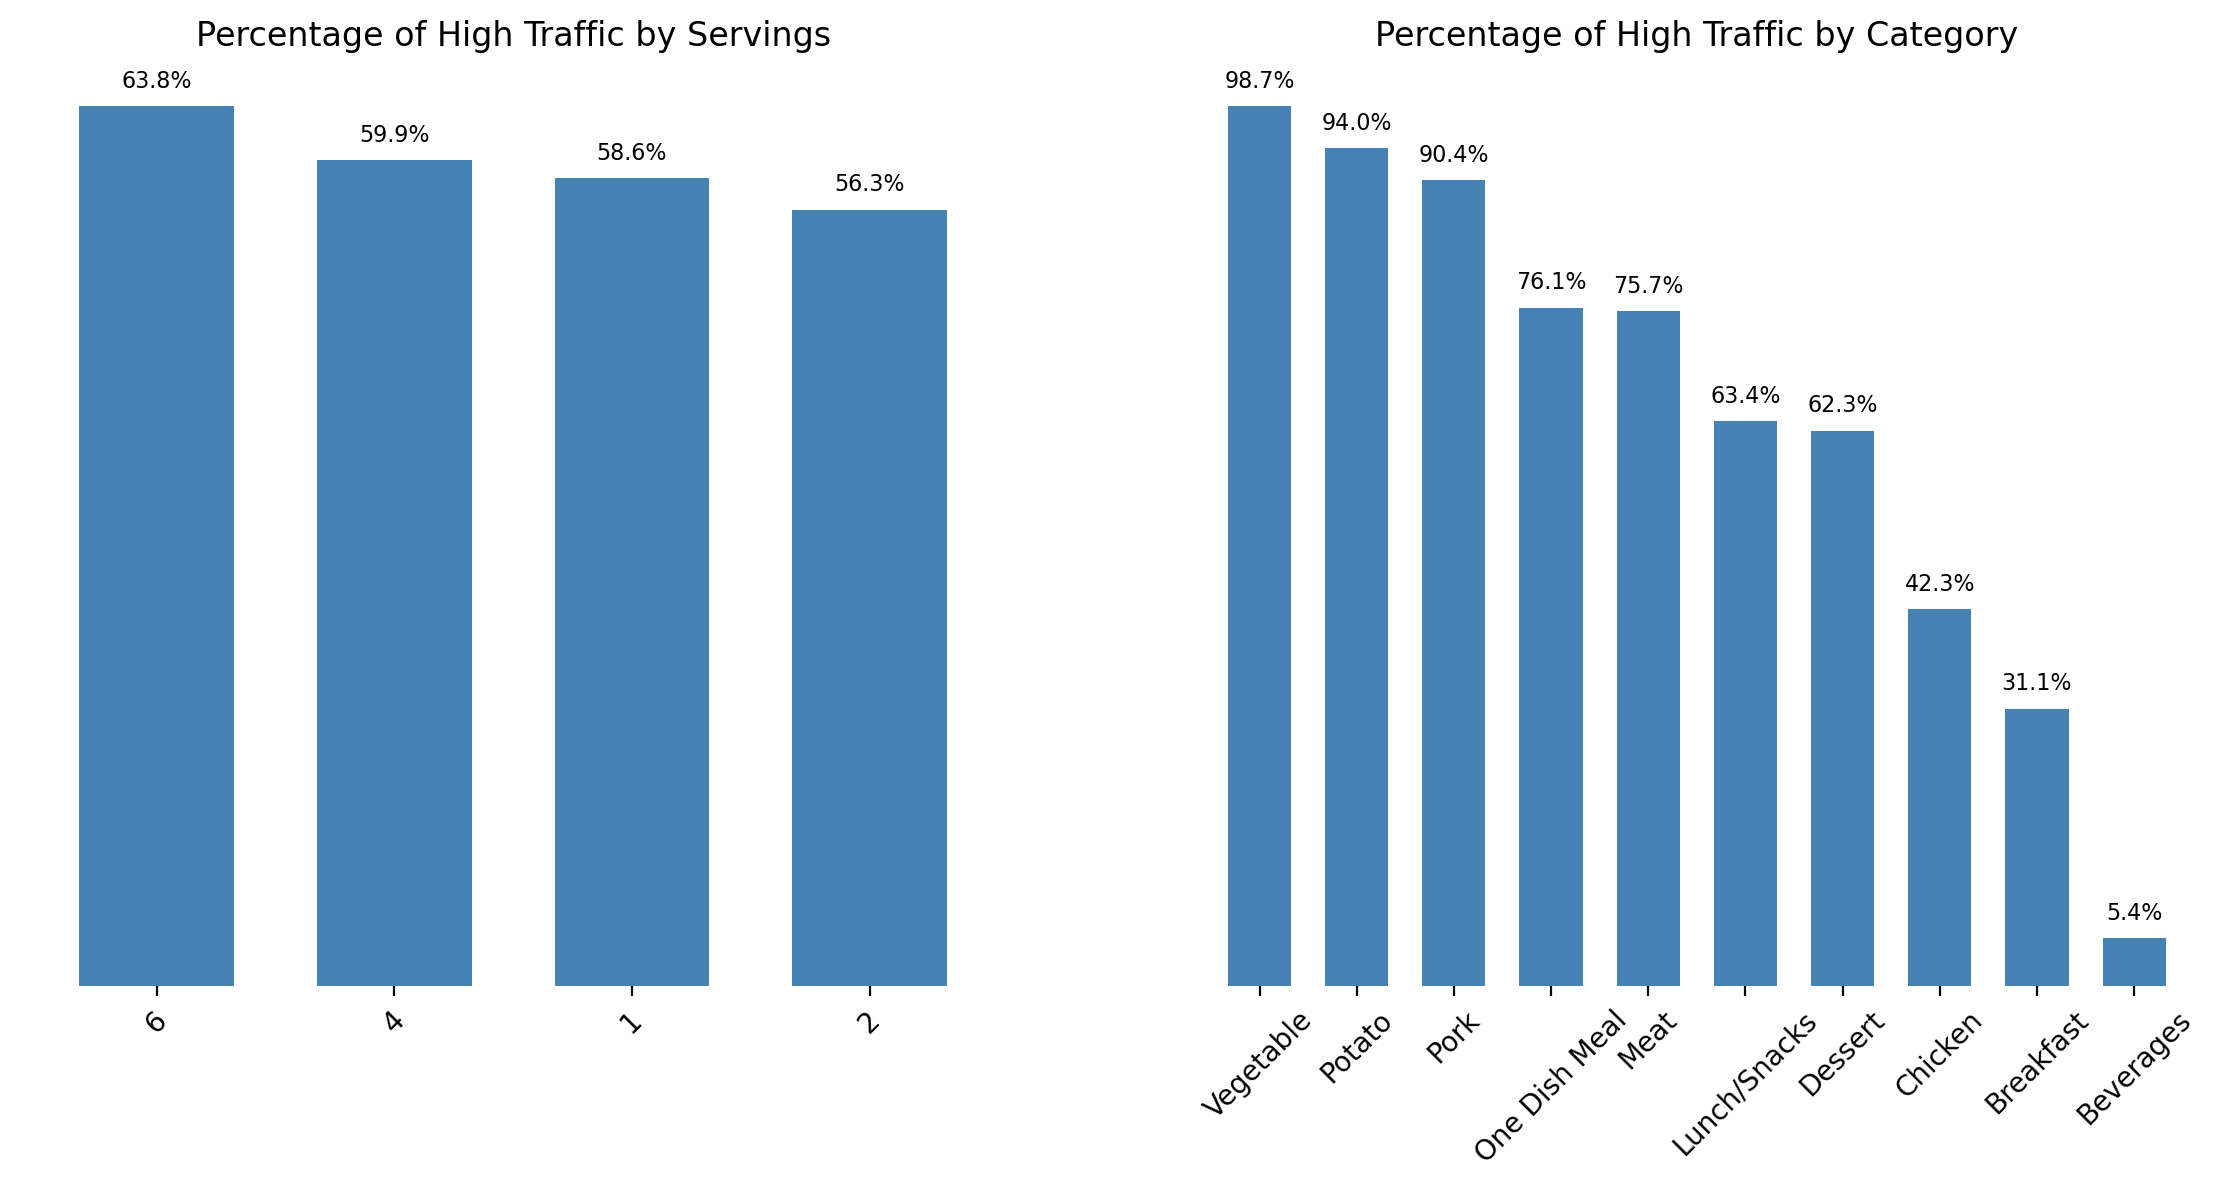

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
for i, col in enumerate(['servings','category']):
    pd.crosstab(df[col], df['high_traffic'], normalize='index').apply(lambda r: round(r*100,1)
                )['High'].sort_values(ascending=False).plot(kind='bar', color='steelblue', width=0.65, ax=ax[i])
    ax[i].set(title=f'Percentage of High Traffic by {col.title()}', xlabel=None, ylabel=None, yticks=[])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
    ax[i].spines[:].set_visible(False)
    for p in ax[i].containers: ax[i].bar_label(p, fmt='%.1f%%', label_type='edge', padding=5, fontsize=8)
plt.show()

- From the plots above, it appears that the number of servings per recipe does not have a significant effect on the traffic level.
- In contrast, it is evident that the category of the recipe has a considerable influence, as indicated by the significant variations observed.
- Specifically, categories such as Vegetables, Potato, and Pork tend to have high traffic levels for more than 90% of the recipes. Conversely, the category of Beverages, for example, shows a relatively low proportion of high traffic at only 5.4%.

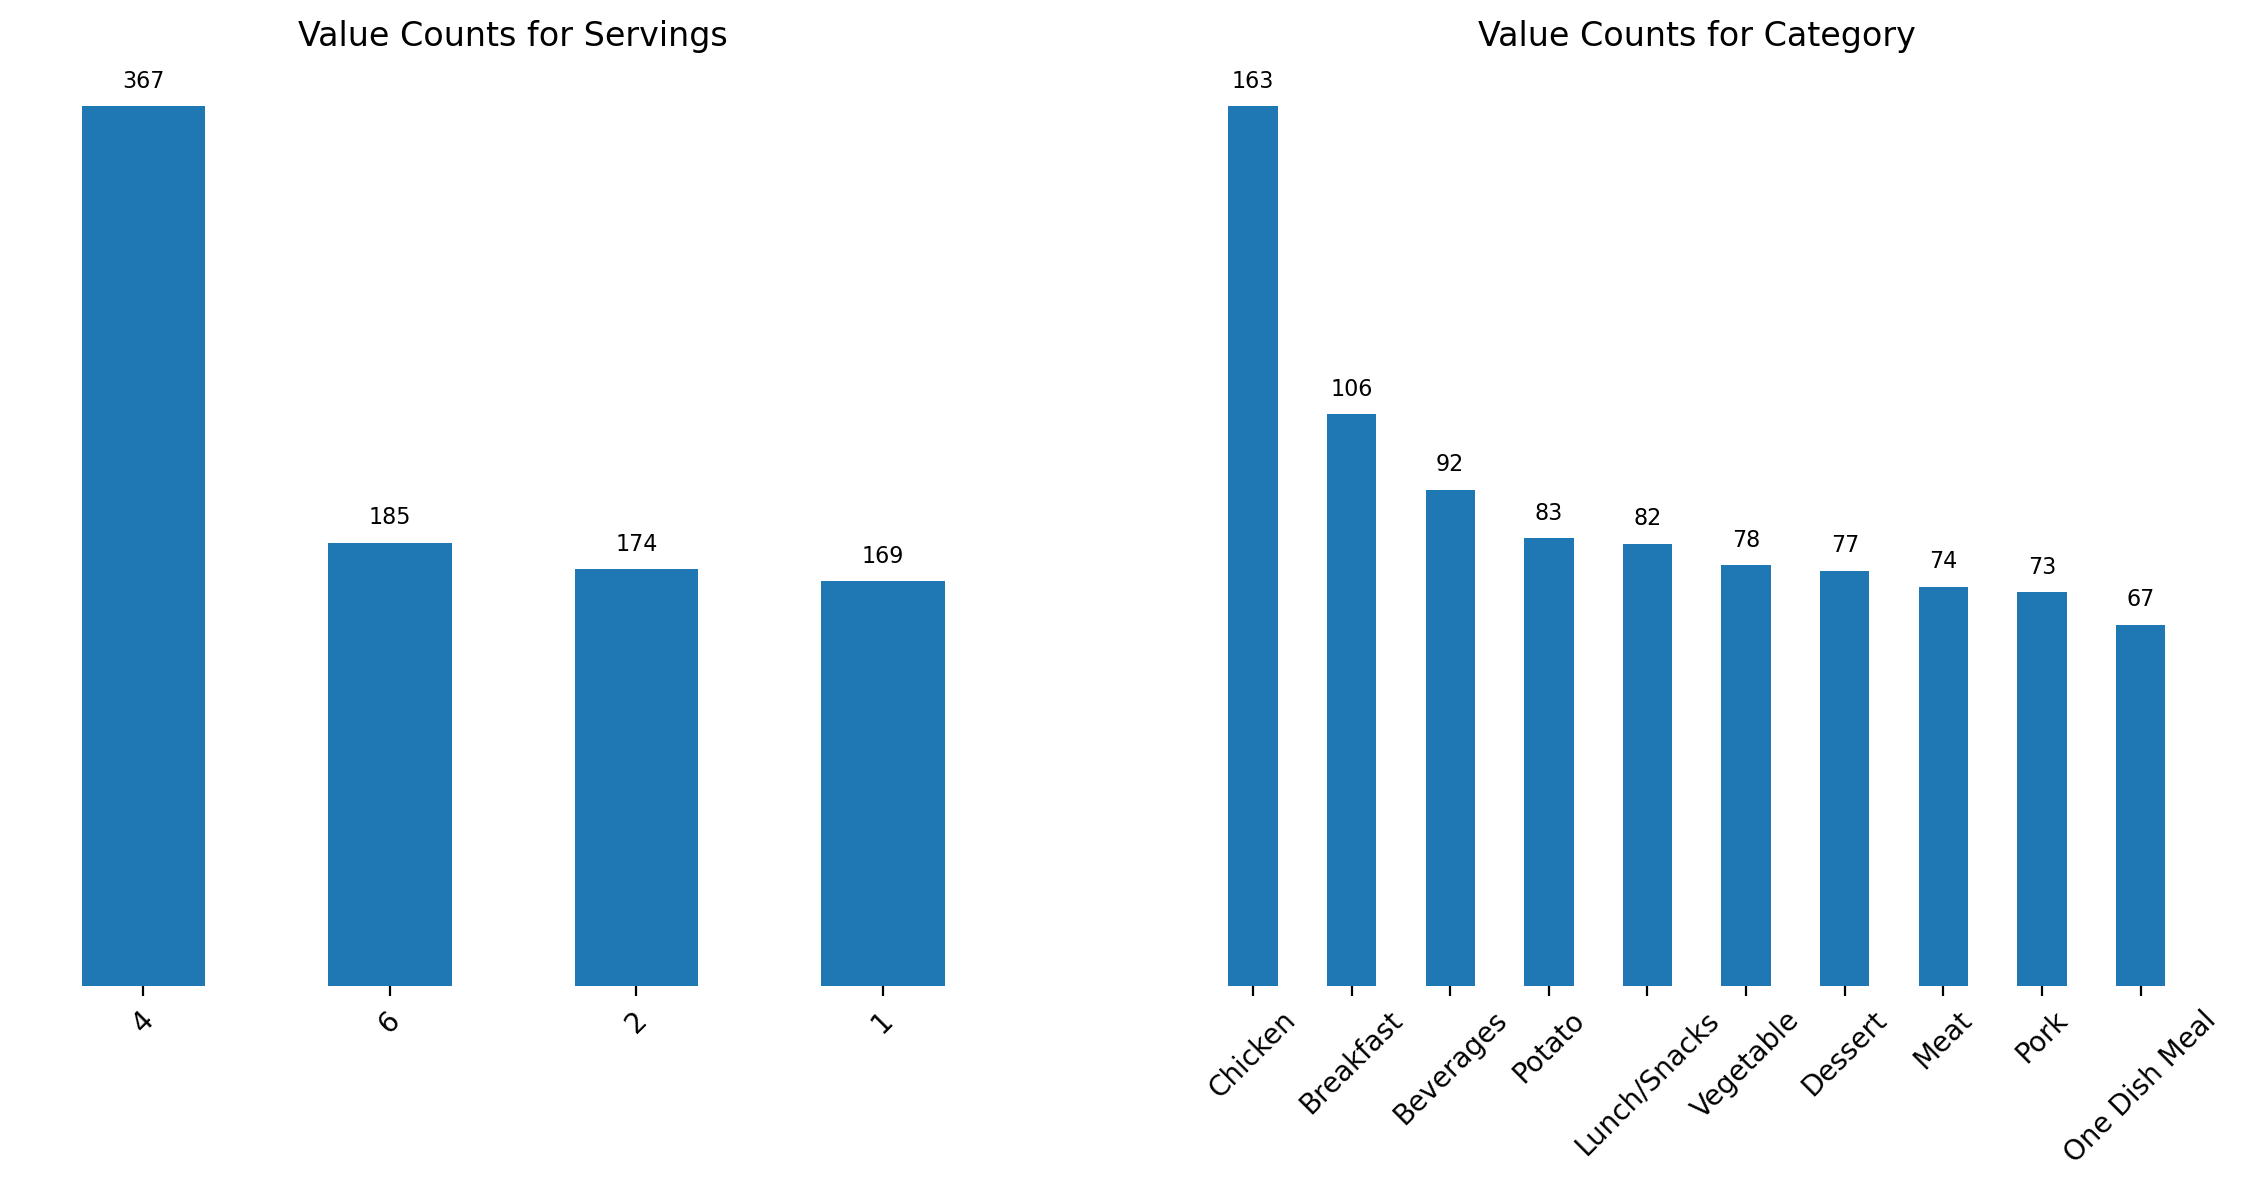

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
for i, col in enumerate(['servings','category']):
    df[col].value_counts().plot(kind='bar', ax=ax[i])
    ax[i].set(title=f'Value Counts for {col.title()}', xlabel=None, ylabel=None, yticks=[])
    ax[i].spines[:].set_visible(False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
    for p in ax[i].containers: ax[i].bar_label(p, label_type='edge', padding=5, fontsize=8)
plt.show()

- The plots above are a visual representation of the count of each recipe by number of serving and by its category.
- Upon comparing these plots with the previously displayed plots illustrating the high traffic rate, it becomes evident that there is no discernible relationship between the number of recipes per category or the number of servings and the traffic.

- Now, let's proceed with the analysis of the nutritional characteristics of each recipe.
- To facilitate the analysis, we will first create a list specifically containing the nutrition columns.

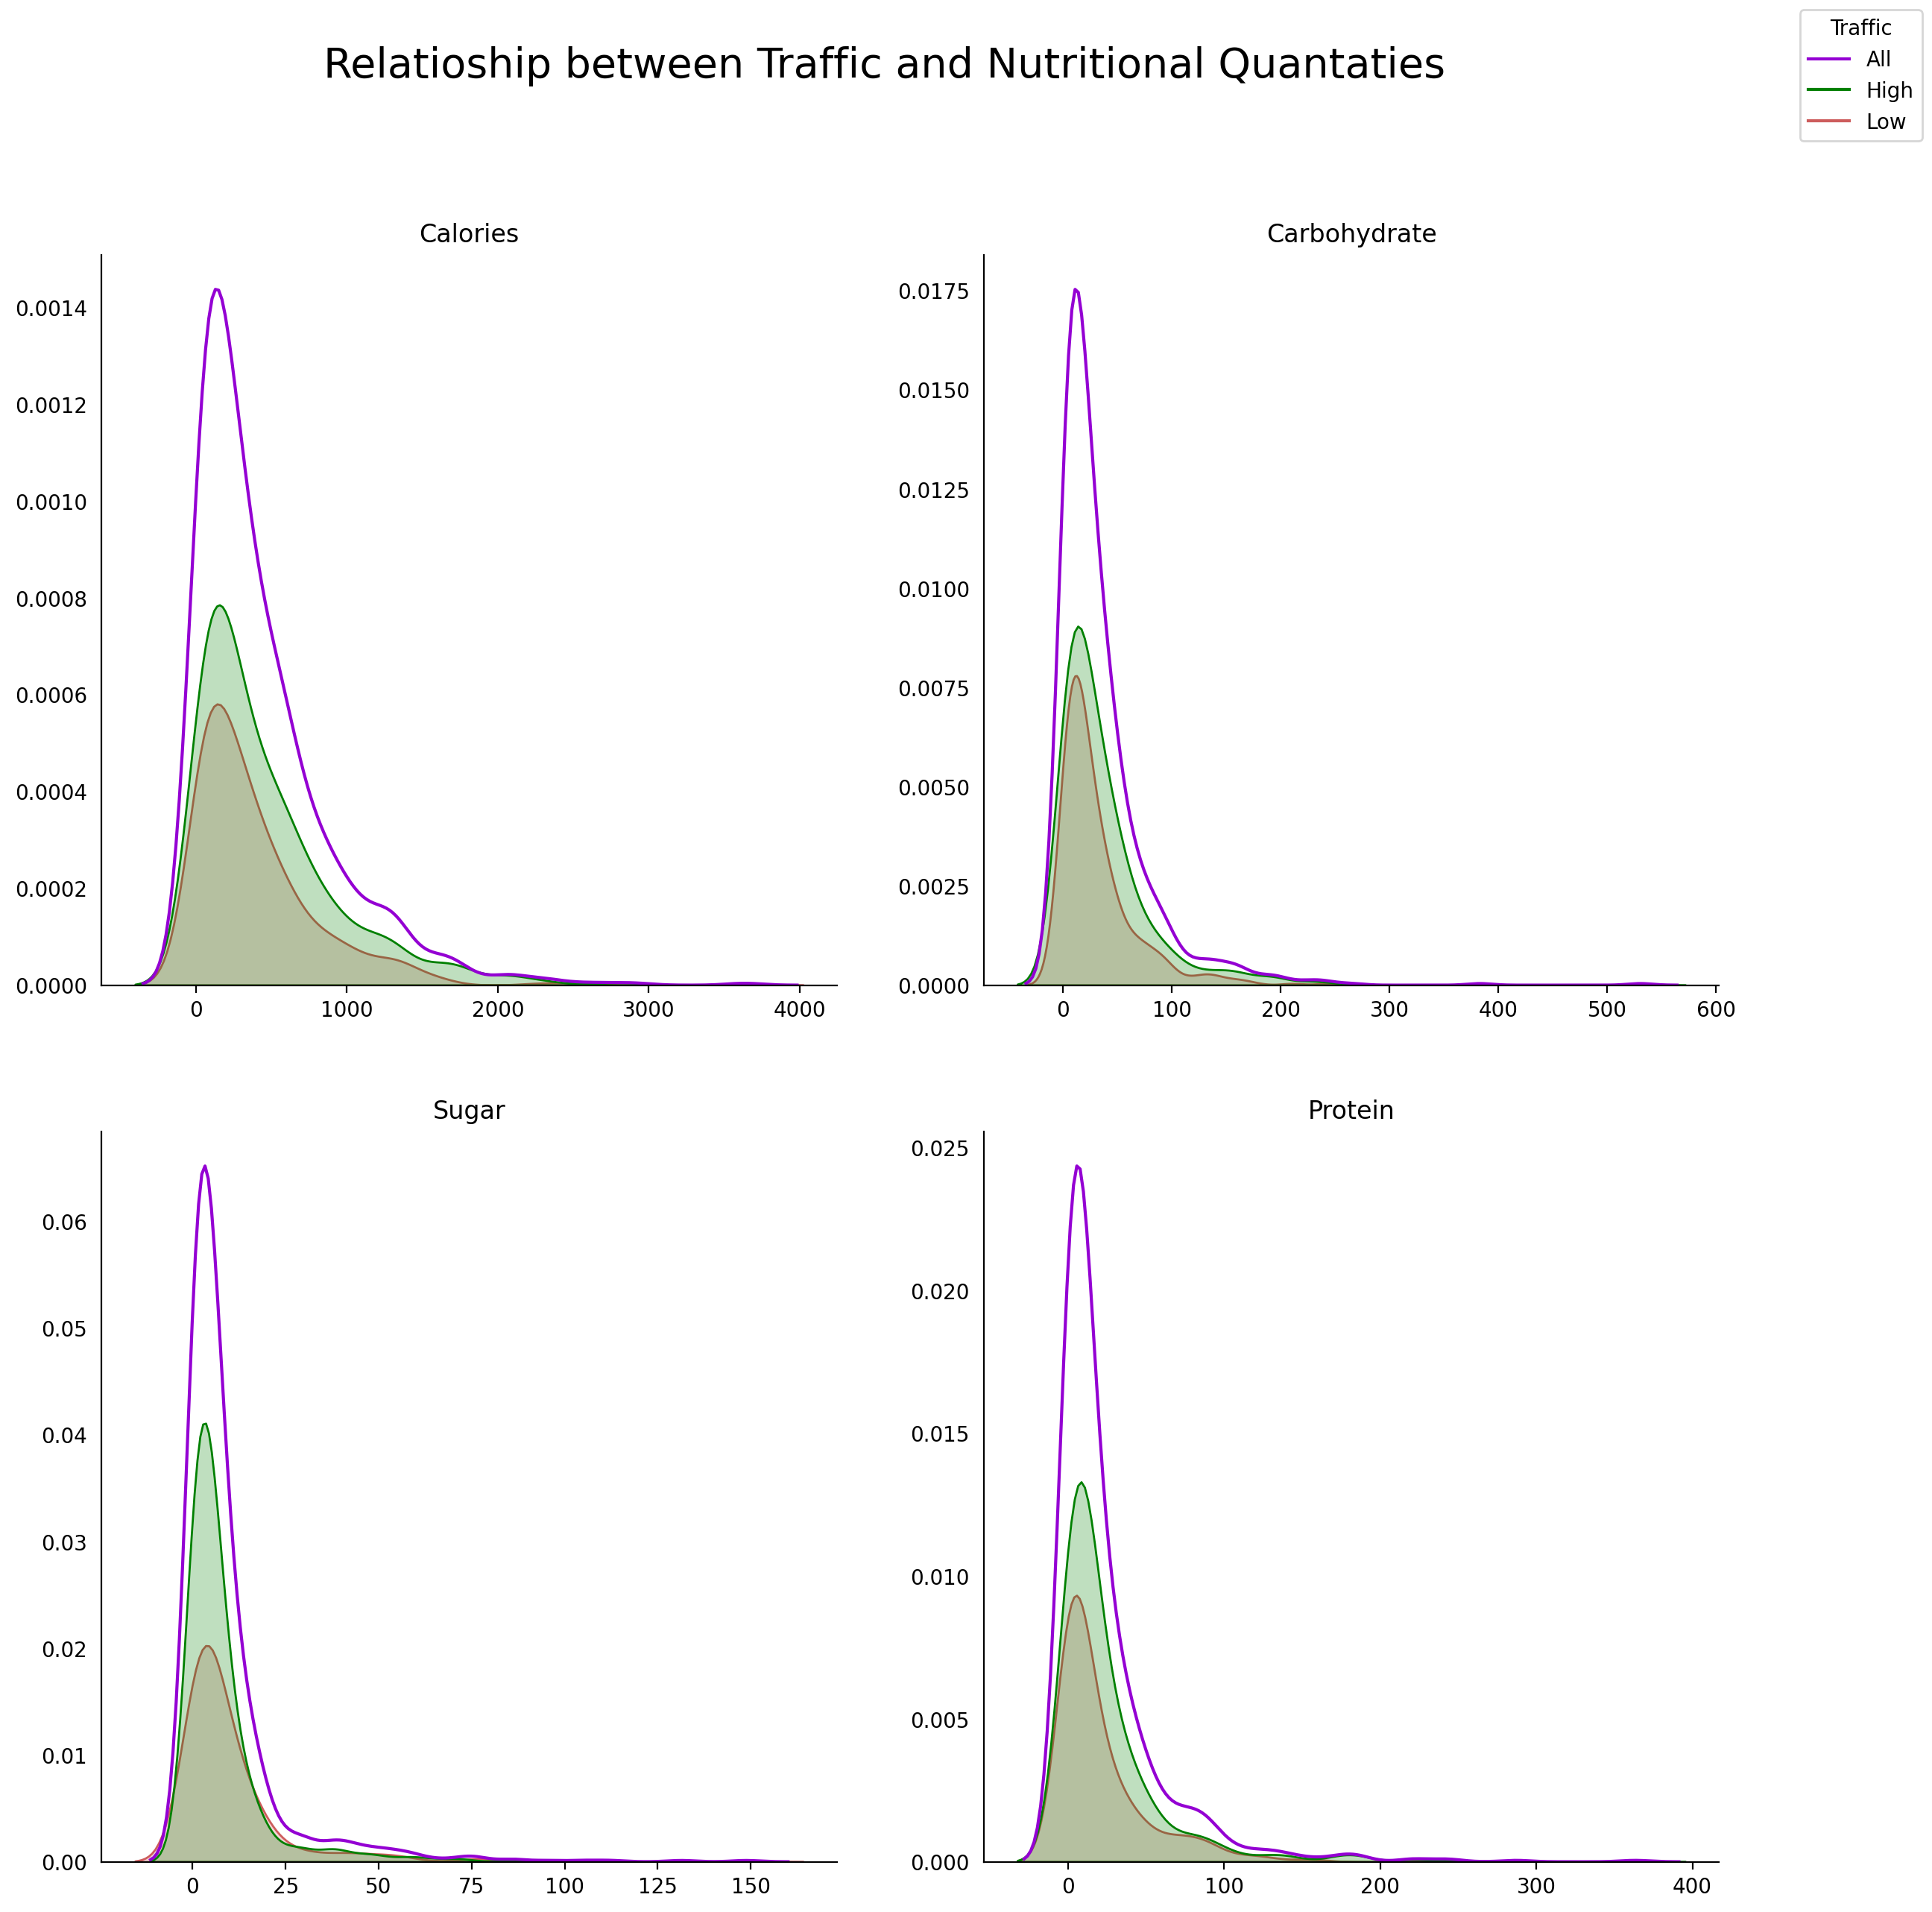

In [11]:
nutrition_cols = [col for col in col_lists(df)[0] if col != 'servings']
color_dict = {'All':'darkviolet', 'High':'green', 'Low':'indianred'}

fig, ax = plt.subplots(2, 2, figsize=(14,14))
for i, col in enumerate(nutrition_cols):
    ax_i = ax[i//2, i%2]
    sns.kdeplot(data=df, x=col, hue='high_traffic', fill=True, palette=color_dict, ax=ax_i)
    sns.kdeplot(df[col], ax=ax_i, color=color_dict['All'])
    ax_i.tick_params(left=False)
    ax_i.spines[['top','right']].set_visible(False)
    ax_i.set(xlabel=None, ylabel=None,title=col.title())
    ax_i.legend_.remove()

fig.suptitle('Relatioship between Traffic and Nutritional Quantaties', fontsize=20)
handles = [plt.Line2D([], [], color=color, label=label) for label, color in color_dict.items()]
fig.legend(handles=handles, labels=color_dict.keys(), loc='upper right', title='Traffic')

plt.show()

- The similarity in the spread of nutritional features between recipes that generated high and low traffic indicates that these specific nutritional attributes have limited influence on the overall traffic.

- After the features in the dataset have been plotted against the traffic, it is beneficial to examine their relationships with each other to identify any potential correlations. This can be achieved through two visualization techniques:
    1. Correlation Matrix Heatmap: By creating a heatmap of the correlation matrix, we can visualize the strength and direction of correlations between the features.
    2. Pair Plot of Scatterplots: Another useful method is to generate a pair plot consisting of scatterplots for each pair of features. This enables us to observe potential patterns or relationships between variables.

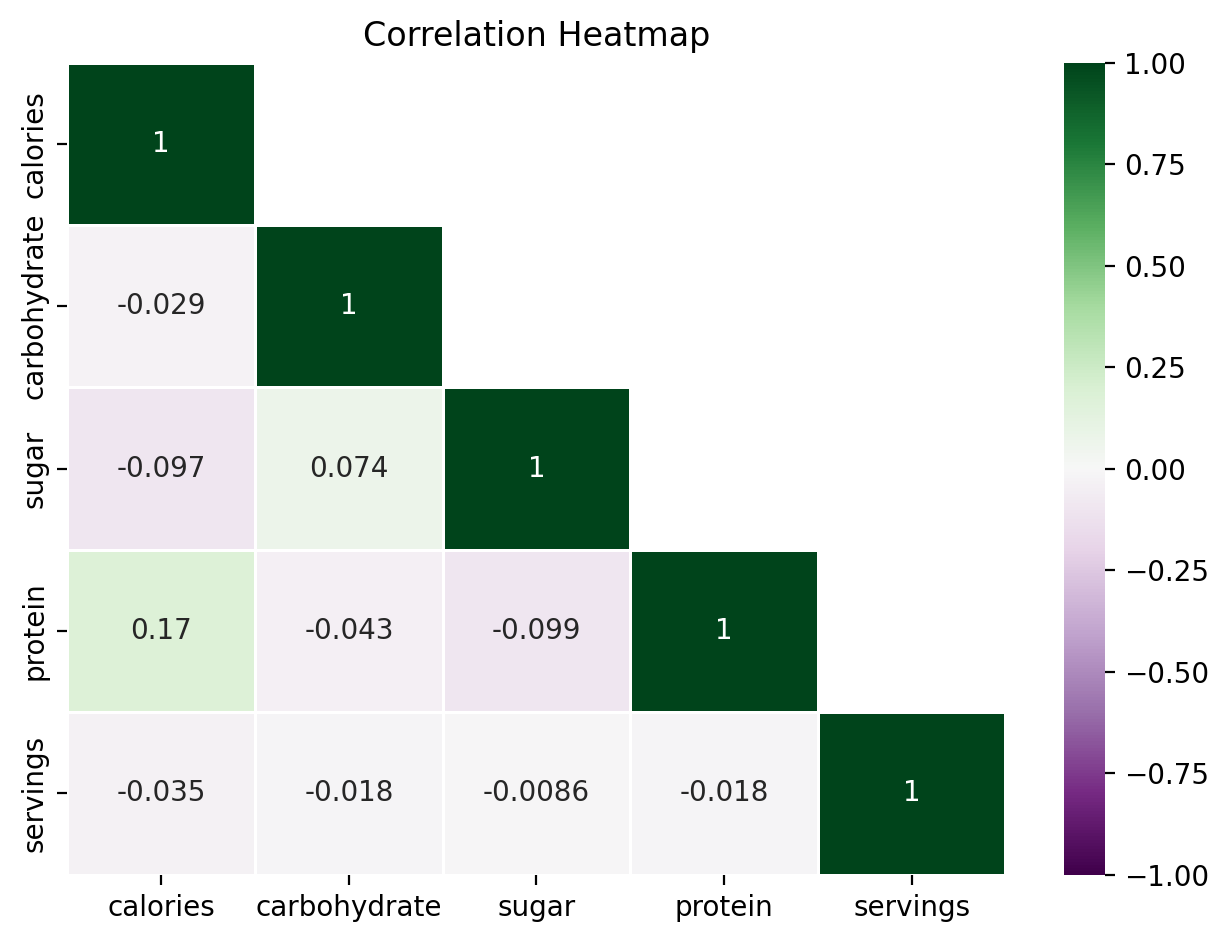

In [26]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, linewidth=0.5, cmap='PRGn',
            mask=np.tri(df.corr().shape[0], k=-1).T).set_title("Correlation Heatmap")
plt.tight_layout()
plt.show()

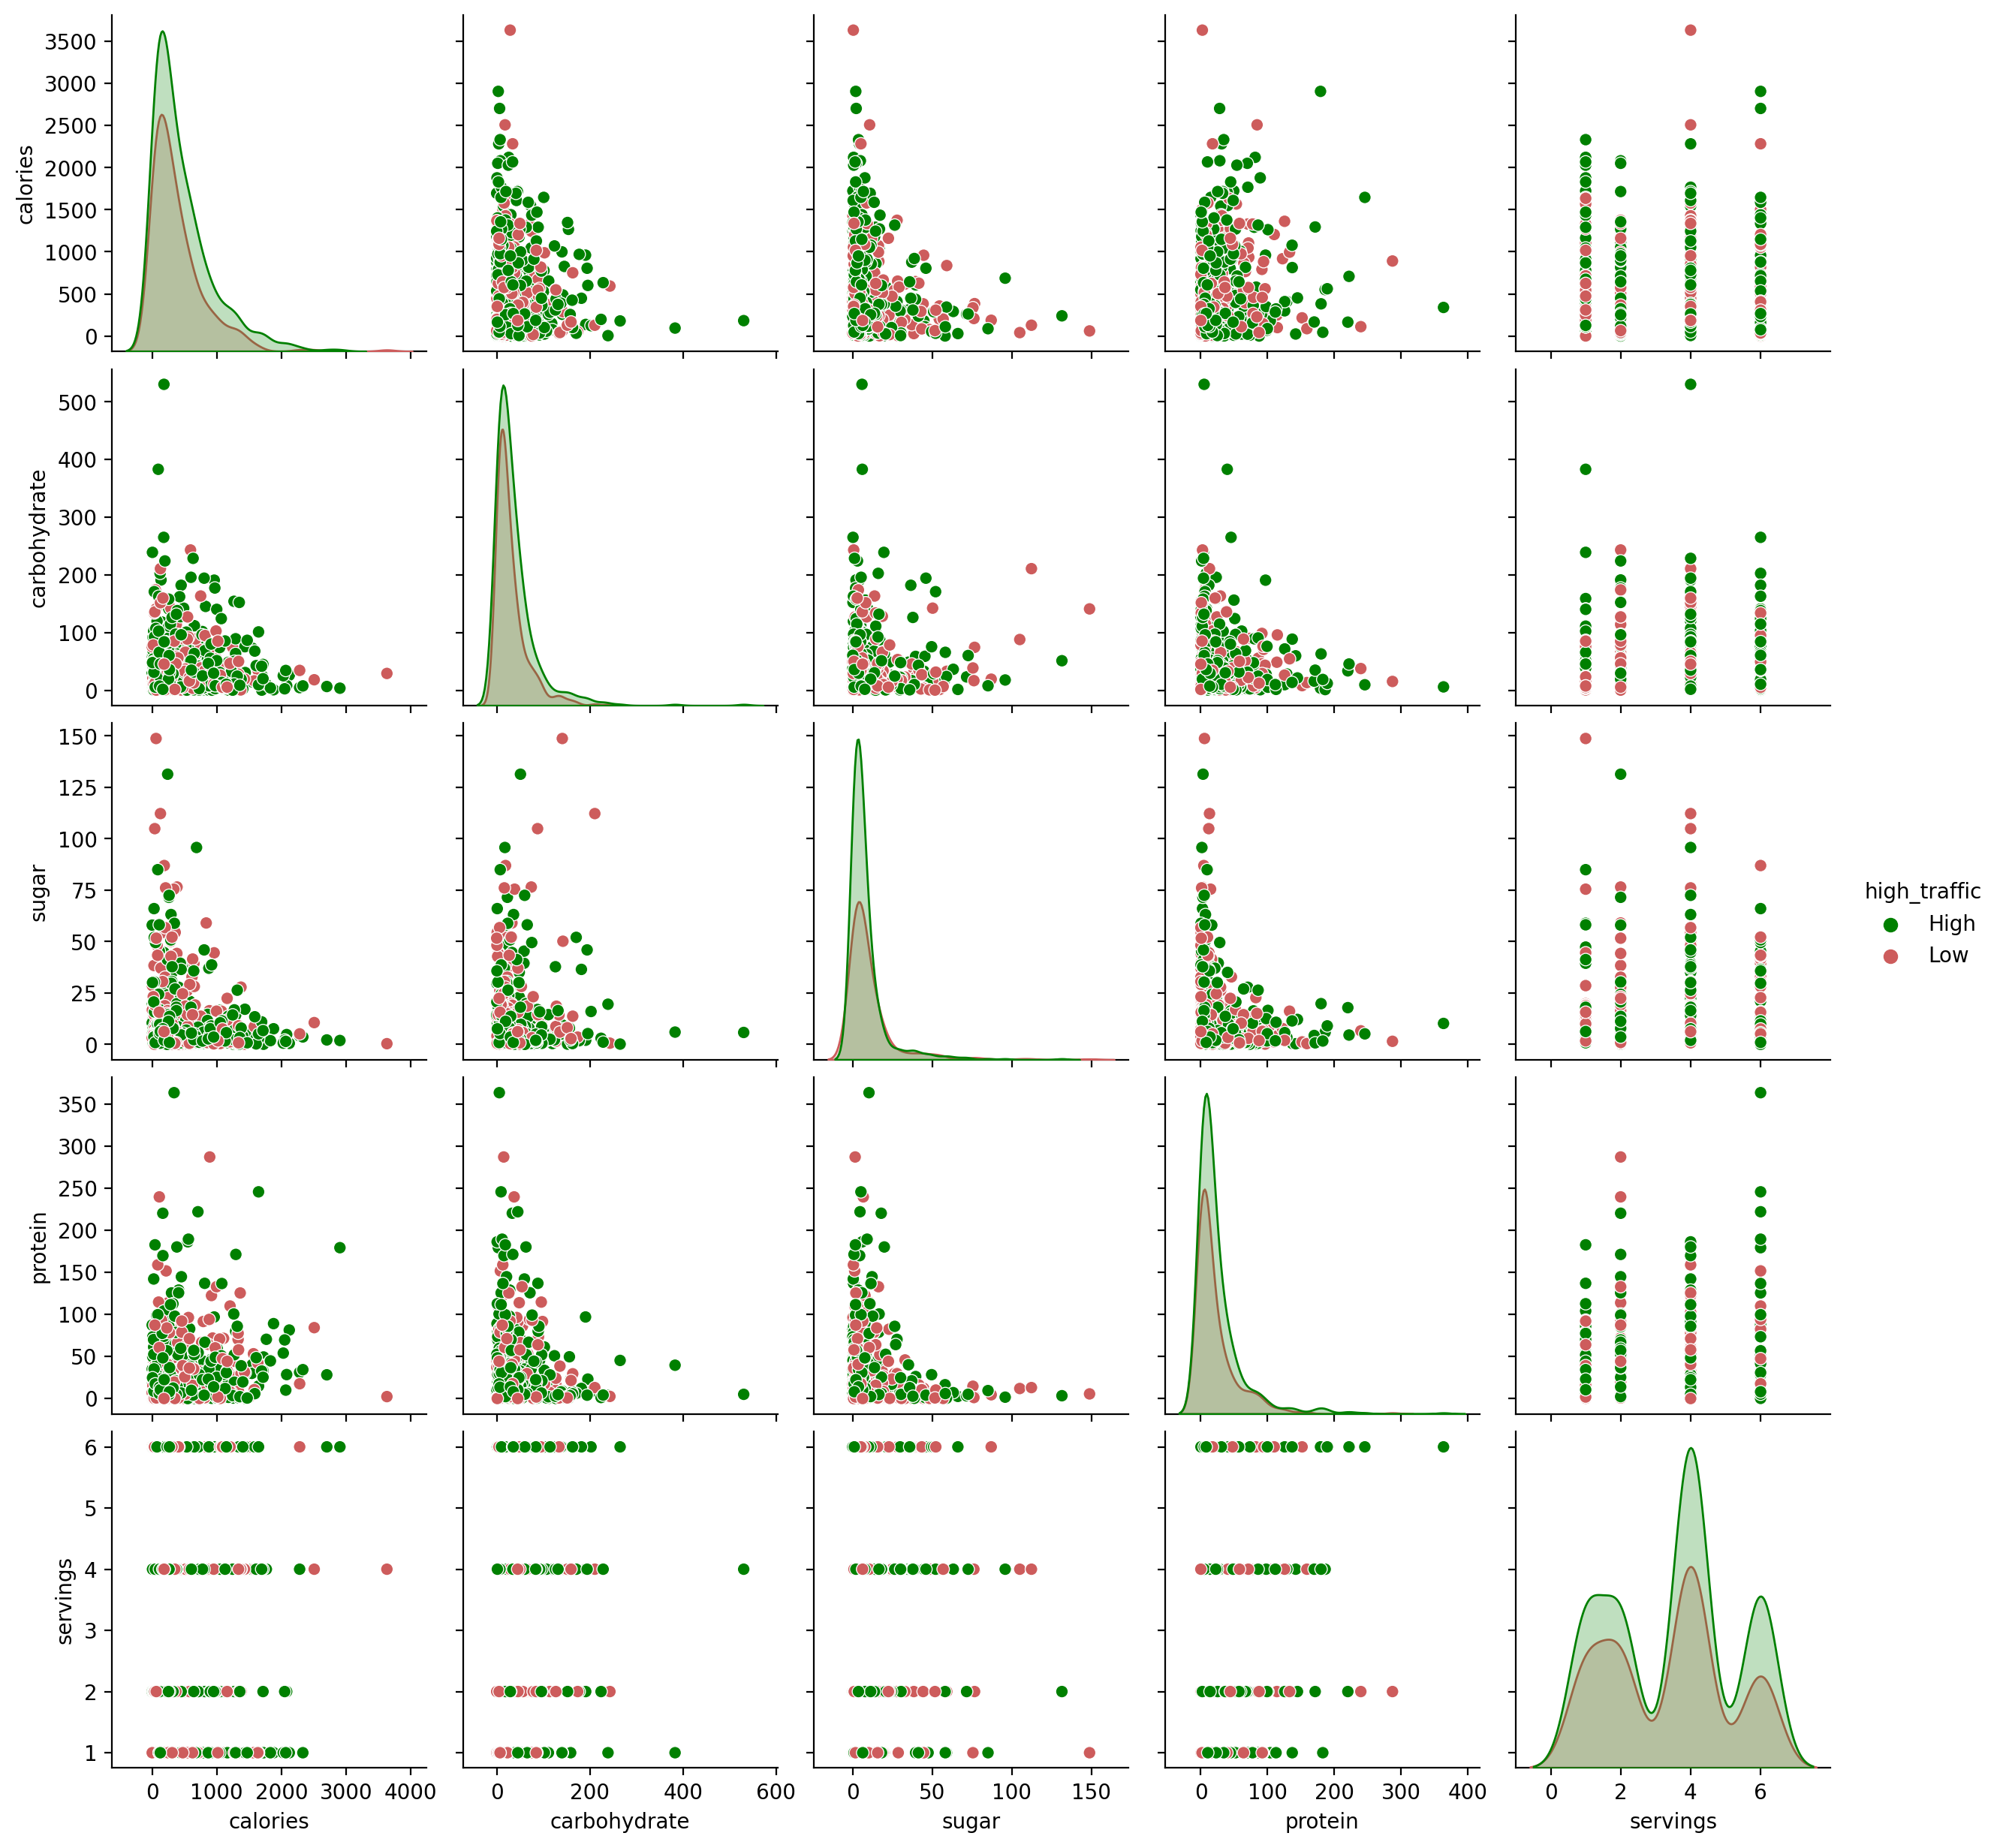

In [13]:
sns.pairplot(df, hue='high_traffic', palette=color_dict, kind='scatter')
plt.show()

- The Correlation Matrix Heatmap and Pair Plot analysis reveal a lack of significant correlations among the features within the dataset.
- This absence of correlation between the features could be beneficial as it reduces the presence of multicollinearity. By minimizing multicollinearity, we can ensure more accurate and robust interpretations of the relationships between individual features and the target variable.

- In preparation for the upcoming plot and model development, it is necessary to edit and transform the dataframe.
- This involves creating a dummified dataframe for the features (X) and a separate one for the label (y).

In [14]:
X = pd.get_dummies(df.drop('high_traffic', axis=1), drop_first=True)
y = df['high_traffic'].map({'High': 1, 'Low': 0})

- Next, we will employ various dimensionality reduction techniques and plot the results.
- Visualizing the data after dimensionality reduction offers several advantages, including assessing the distribution of data, understanding the variance explained by each component, identifying significant features, analyzing clusters or groups, and detecting outliers.

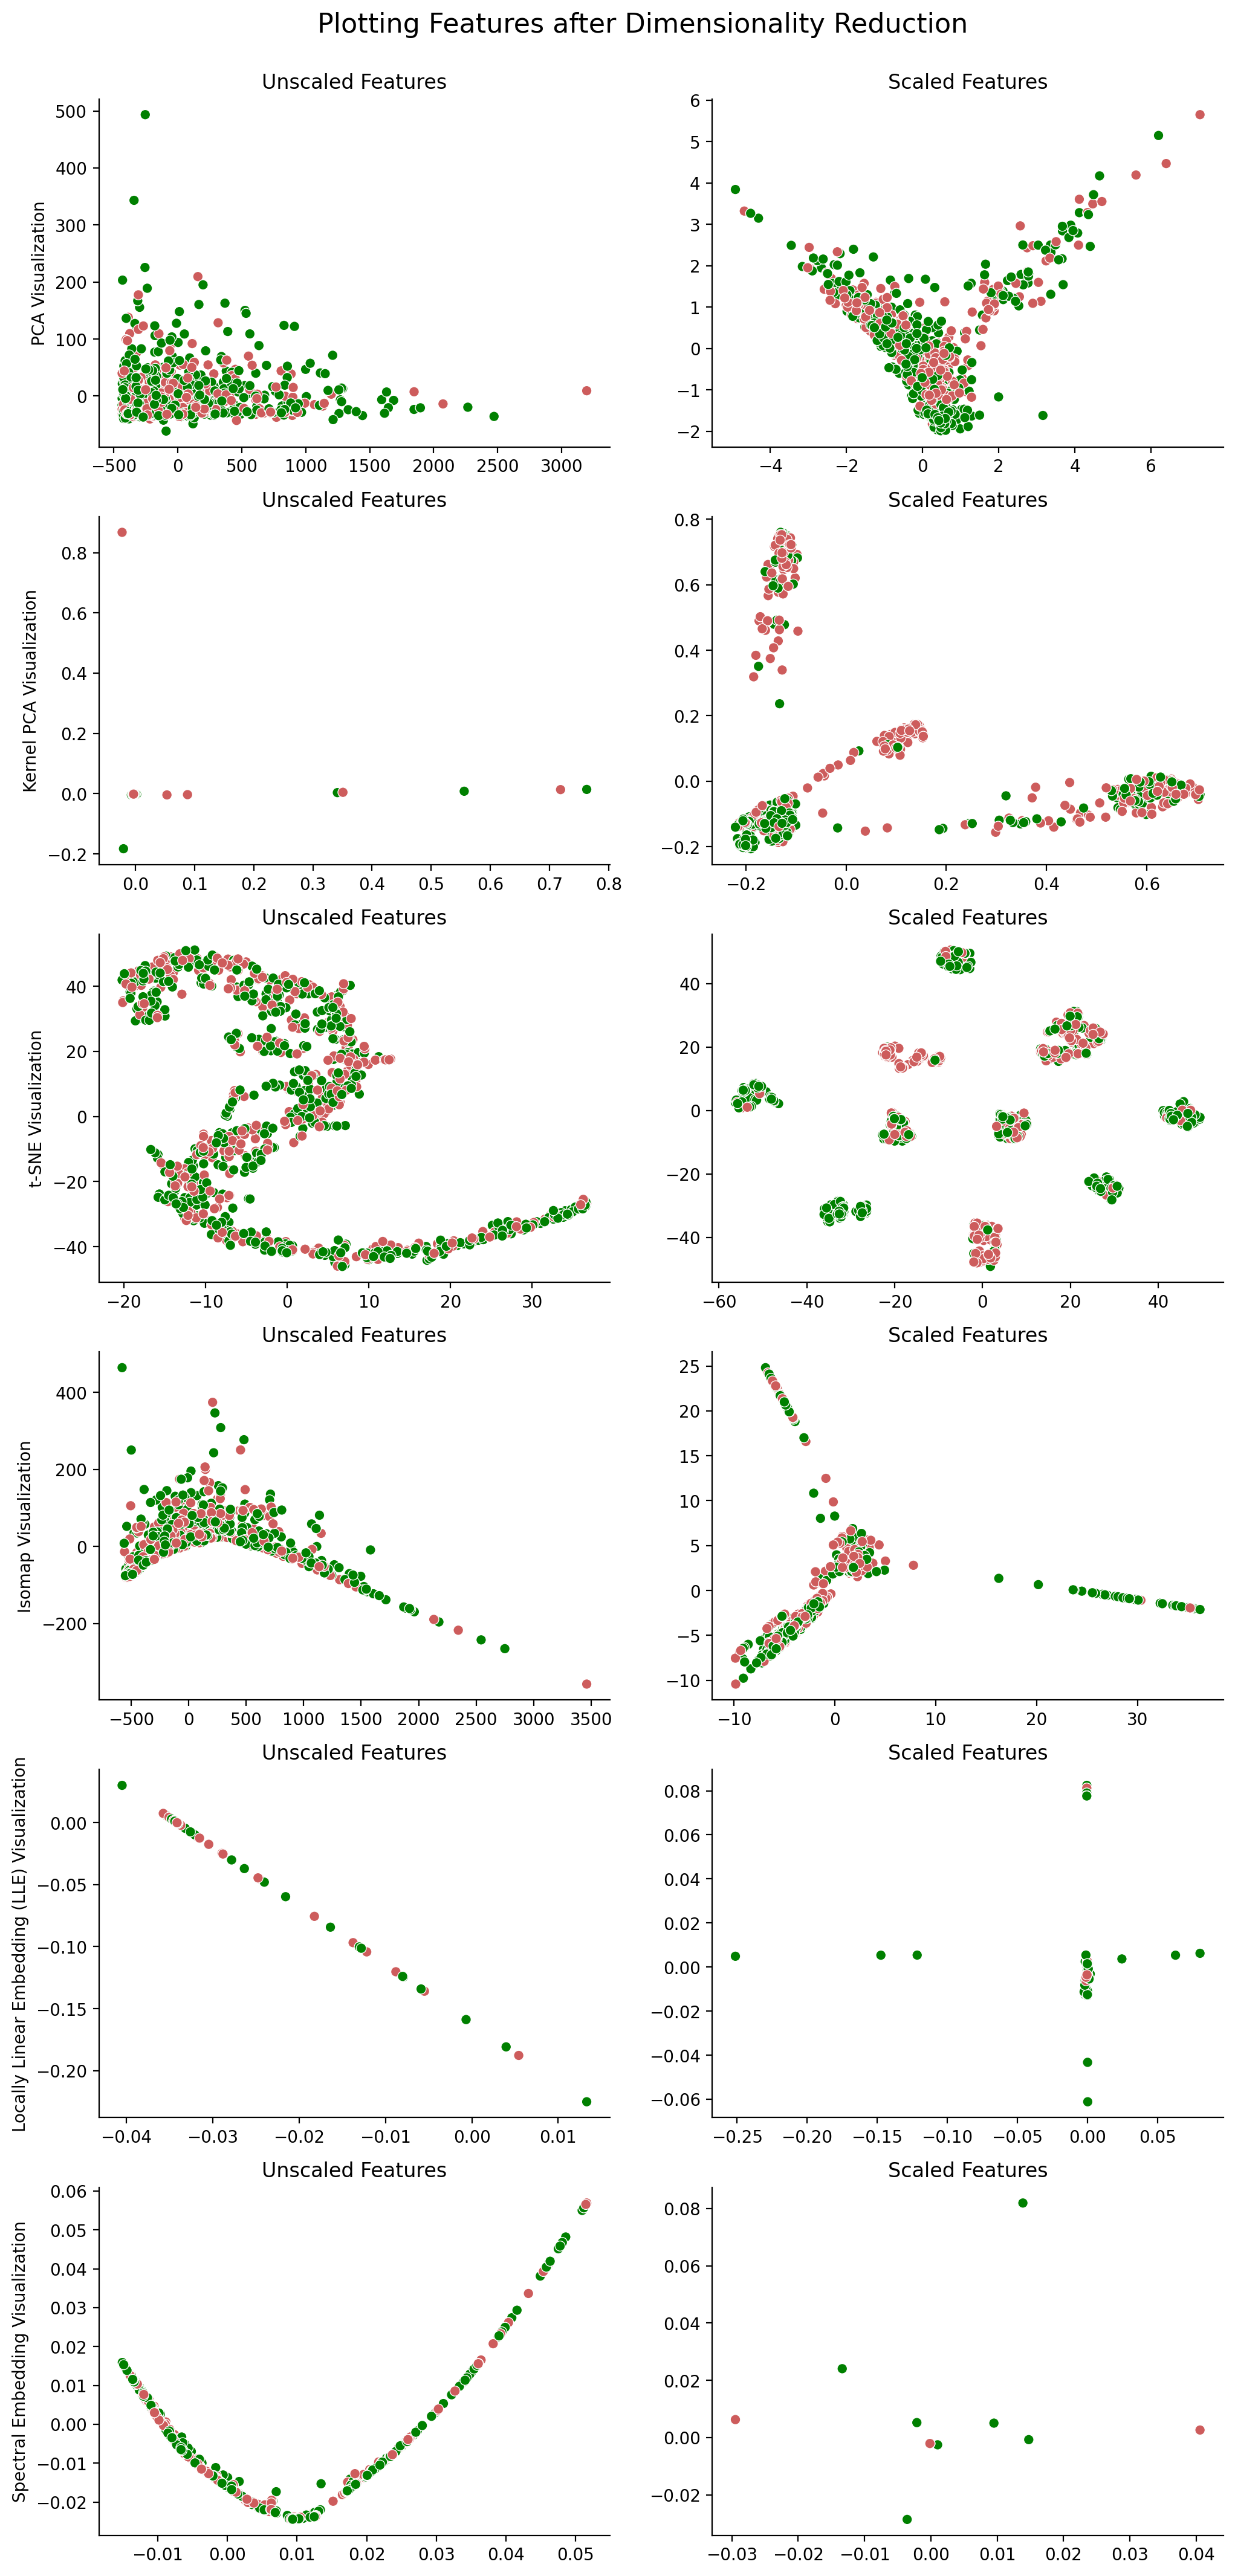

In [15]:
def plot_embedding_methods(X, y):
    """# Function to plot features after dimensionality reduction using various methods"""

    # Create a list of dataframes for the dataset with and without scaling
    dataframes = [X, StandardScaler().fit_transform(X)]

    # Define a list of dimensionality reduction methods with their names and corresponding reducers
    methods = [
        ("PCA", PCA(n_components=2, random_state=seed)),
        ("Kernel PCA", KernelPCA(n_components=2, kernel='rbf', random_state=seed)),
        ("t-SNE", TSNE(n_components=2, random_state=seed)),
        ("Isomap", Isomap(n_components=2, n_neighbors=5)),
        ("Locally Linear Embedding (LLE)", LocallyLinearEmbedding(n_components=2, n_neighbors=5, random_state=seed)),
        ("Spectral Embedding", SpectralEmbedding(n_components=2, n_neighbors=5, random_state=seed)),
    ]

    # Get the number of methods and dataframes
    n_methods = len(methods)
    n_dataframes = len(dataframes)

    # Create subplots for the plots
    fig, ax = plt.subplots(n_methods, n_dataframes, figsize=(12, 4 * n_methods))
    fig.suptitle("Plotting Features after Dimensionality Reduction", fontsize=16)
    plt.subplots_adjust(top=0.95)

    # Iterate over the methods and dataframes to create the plots
    for i, (method, reducer) in enumerate(methods):
        for j, df in enumerate(dataframes):
            # Perform dimensionality reduction on the dataframe
            X_embedding = reducer.fit_transform(df)
            # Plot the scatterplot with colors based on the target variable
            ax_i = ax[i, j]
            sns.scatterplot(x=X_embedding[:, 0], y=X_embedding[:, 1], hue=y, palette=color_dict, ax=ax_i)
            ax_i.spines[['top','right']].set_visible(False)
            ax_i.set(xlabel=None, ylabel=f"{method} Visualization" if j == 0 else None,
                     title=f"{'Scaled' if j == 1 else 'Unscaled'} Features")
            ax_i.legend_.remove()

    plt.show()

plot_embedding_methods(X, df['high_traffic'])

<a id='development'></a>
# 4. Model Development

- **The Precision score** score represents the proportion of true positive values among all positive values (true positives and false positives).

- Given our objective of minimizing false positives, which refers to recipes predicted to have high traffic but actually have low traffic, we will employ the **Precision score** as the primary evaluation metric for the upcoming **binary classification models**.

- Additionally, the F1 score and accuracy score will be utilized to provide further insights into the model's performance.

- To promote code reusability and minimize redundancy across the multiple models being developed, the following functions have been defined:

In [16]:
# Create an empty dataframe in which the evaluation results of each model will be stored
models_evaluation = pd.DataFrame(columns=['Model', 'Precision', 'Accuracy', 'F1 Score'])

def evaluate_model(model, X, y):
    """Function to evaluate a model and store the evaluation metrics"""
    global models_evaluation

    # Determine the name of the model based on its type and whether it is fine-tuned or basic
    if isinstance(model, GridSearchCV):
        if isinstance(model.best_estimator_, Pipeline):
            model_name = f'{model.best_estimator_.steps[-1][1].__class__.__name__} (fine-tuned)'
        else:
            model_name = f'{model.best_estimator_.__class__.__name__} (fine-tuned)'
    elif isinstance(model, Pipeline):
        model_name = f'{model.steps[-1][1].__class__.__name__} (basic)'
    else:
        model_name = f'{model.__class__.__name__} (basic)'

    # Print the evaluation header
    print(f'Evaluation of {model_name} model:')
    print(f'=' * (len(model_name) + 21))

    # Print the best parameters if the model is a GridSearchCV object
    if isinstance(model, GridSearchCV):
        print("- Best Parameters:")
        for param, value in model.best_params_.items():
            print(f"  . {param.split('__')[1]}: {value}")
        print('')

    # Make predictions using the model
    y_pred = model.predict(X)

    # Calculate and print evaluation metrics
    model_percision = precision_score(y, y_pred)
    model_accuracy = accuracy_score(y, y_pred)
    f1score = f1_score(y, y_pred)
    print(f"- Model Percision is {model_percision:.2f}")
    print(f"- Model Accuracy is {model_accuracy:.2f}")
    print(f"- Model F1-score is {f1score:.2f}")

    # Store the evaluation results in the models_evaluation DataFrame
    models_evaluation.loc[len(models_evaluation)] = [model_name, model_percision, model_accuracy, f1score]

def plot_ConfusionMatrix(model, X, y):
    """Function to plot the confusion matrix for a given model"""
    ConfusionMatrixDisplay.from_estimator(model, X, y, cmap="Blues", display_labels=['Low', 'High']
                                         ).im_.set_clim(vmin=0)
    plt.title('Confusion Matrix')
    plt.show()
    
def plot_FeatureImportance(importance, feature_names):
    """Function to plot the confusion matrix for a given model"""
    # Sort the feature importance and feature names based on the importance values
    sorted_indices = importance.argsort()[::]
    sorted_importance = importance[sorted_indices]
    sorted_feature_names = feature_names[sorted_indices]

    # Plot the feature importance using a horizontal bar chart
    plt.barh(sorted_feature_names, sorted_importance)
    plt.title("Feature Importance")
    plt.tick_params(left=False)
    plt.axvline(x=0, color='black', linewidth=0.5, linestyle=':')
    plt.gca().spines[['right', 'top']].set_visible(False)
    plt.show()

**Model 1: Decision Tree Classifier (base):**

Evaluation of DecisionTreeClassifier (basic) model:
- Model Percision is 0.78
- Model Accuracy is 0.68
- Model F1-score is 0.74


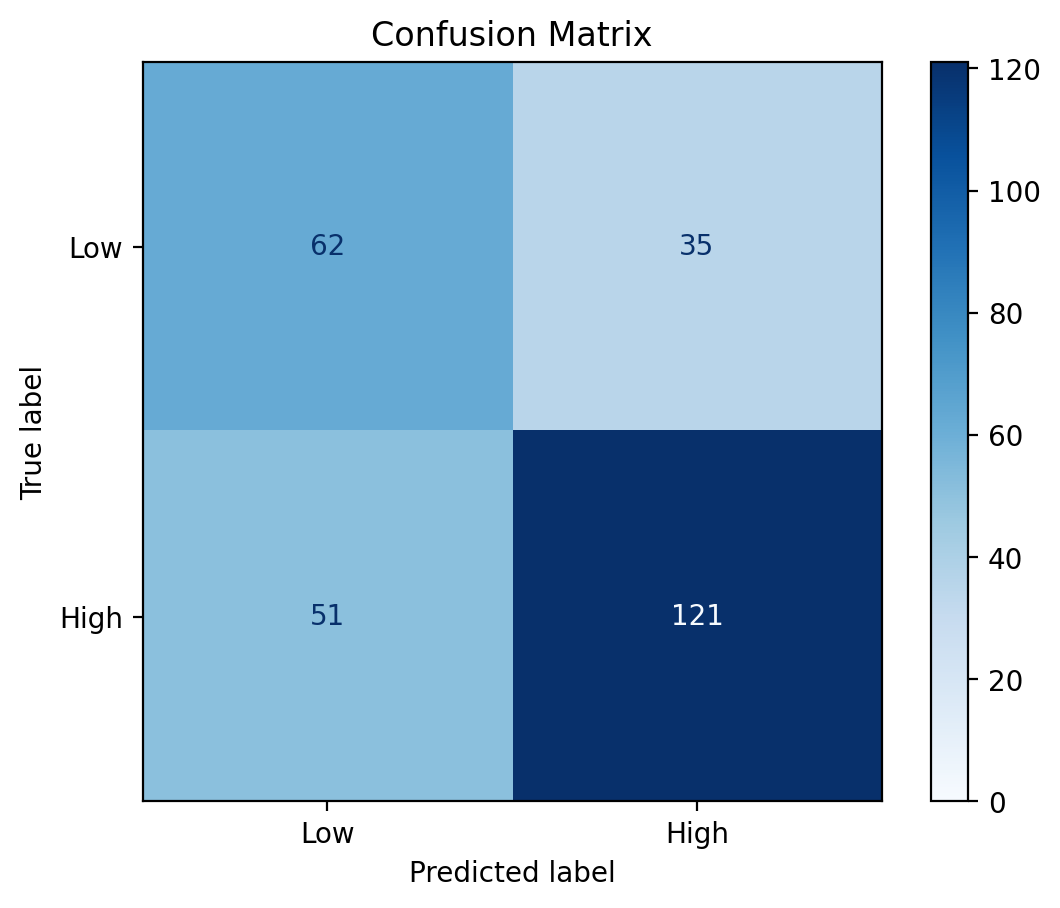

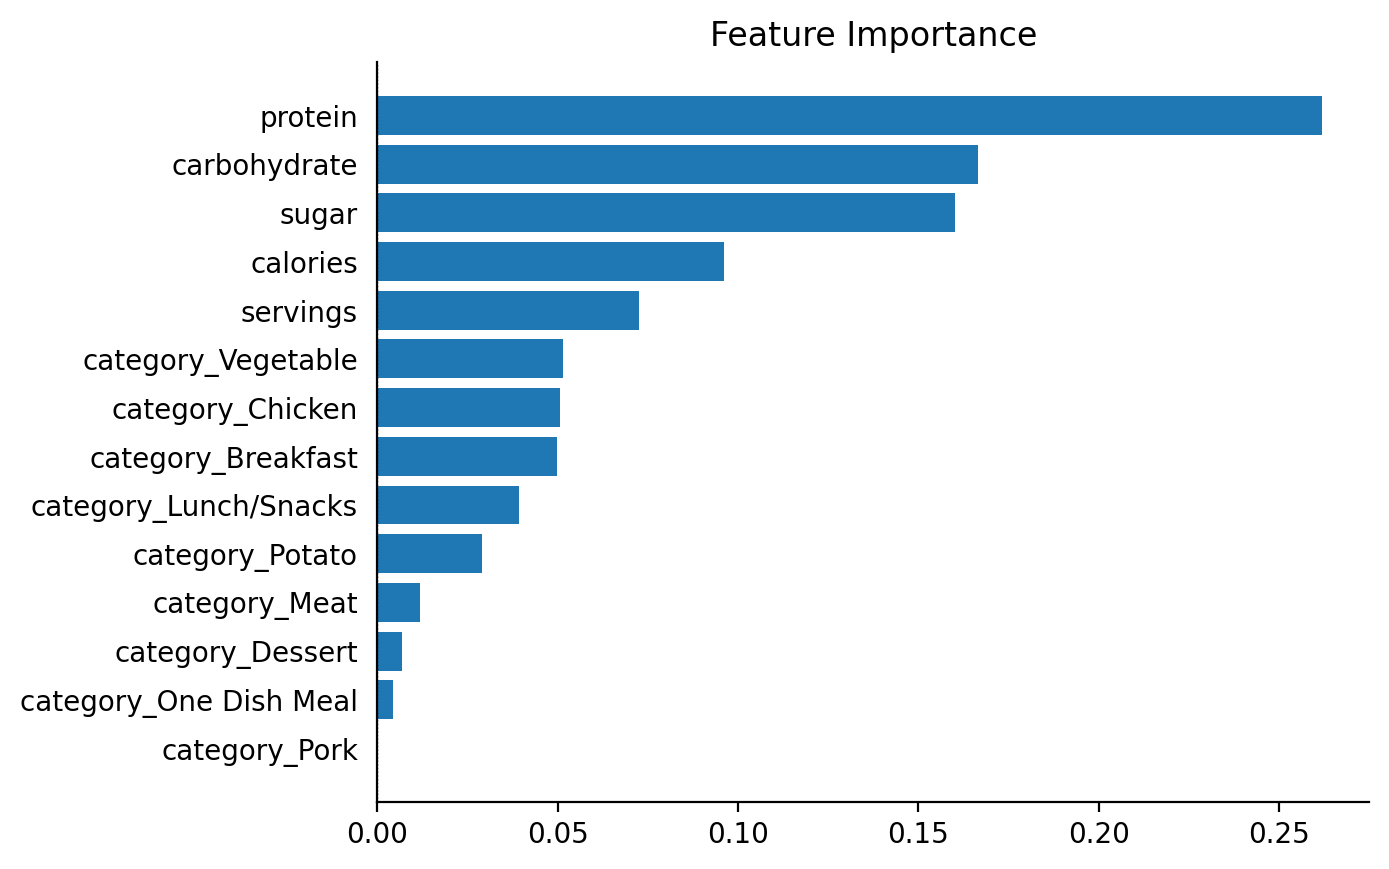

In [17]:
def model_dtc(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    model = Pipeline([('scaler', StandardScaler()),('classifier', DecisionTreeClassifier(random_state=seed))])
    model.fit(X_train, y_train)
    
    importance = model.named_steps['classifier'].feature_importances_
    evaluate_model(model, X_test, y_test)
    plot_ConfusionMatrix(model, X_test, y_test)
    plot_FeatureImportance(importance, X.columns)
    
model_dtc(X, y)

**Model 2: Logistic Regression (base):**

Evaluation of LogisticRegression (basic) model:
- Model Percision is 0.87
- Model Accuracy is 0.79
- Model F1-score is 0.83


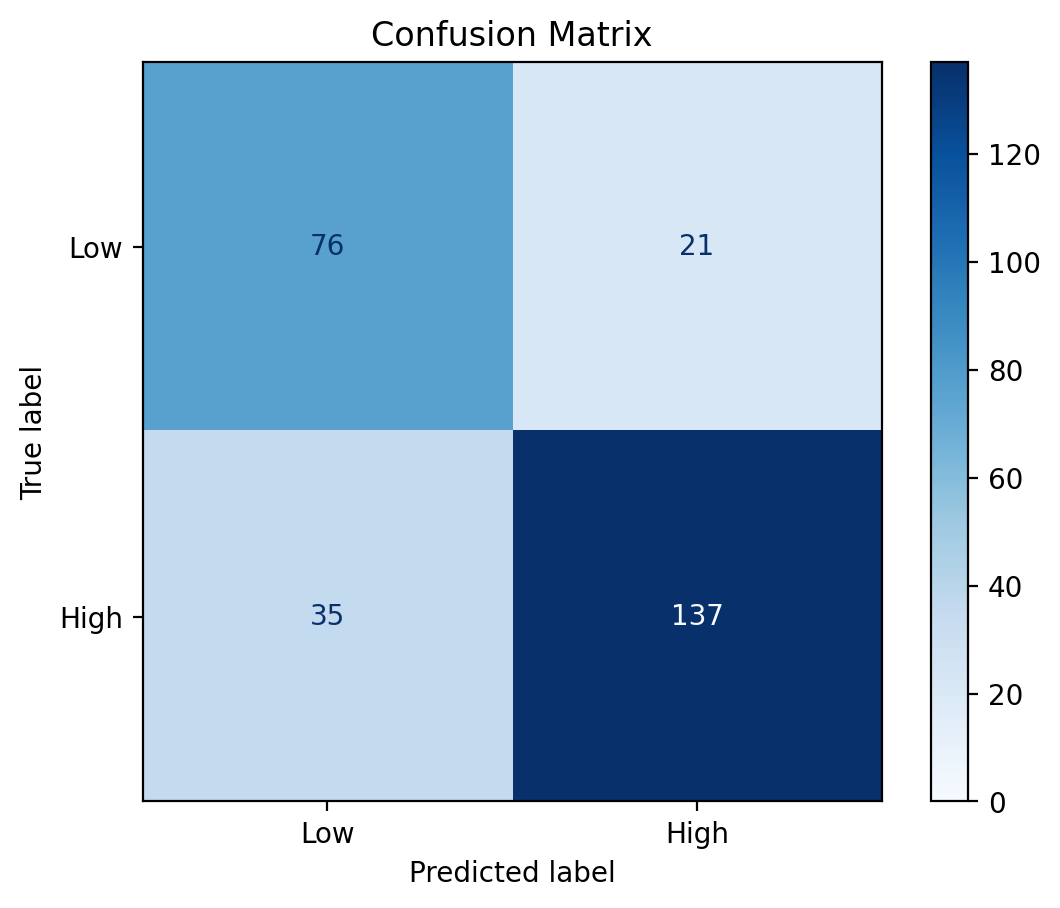

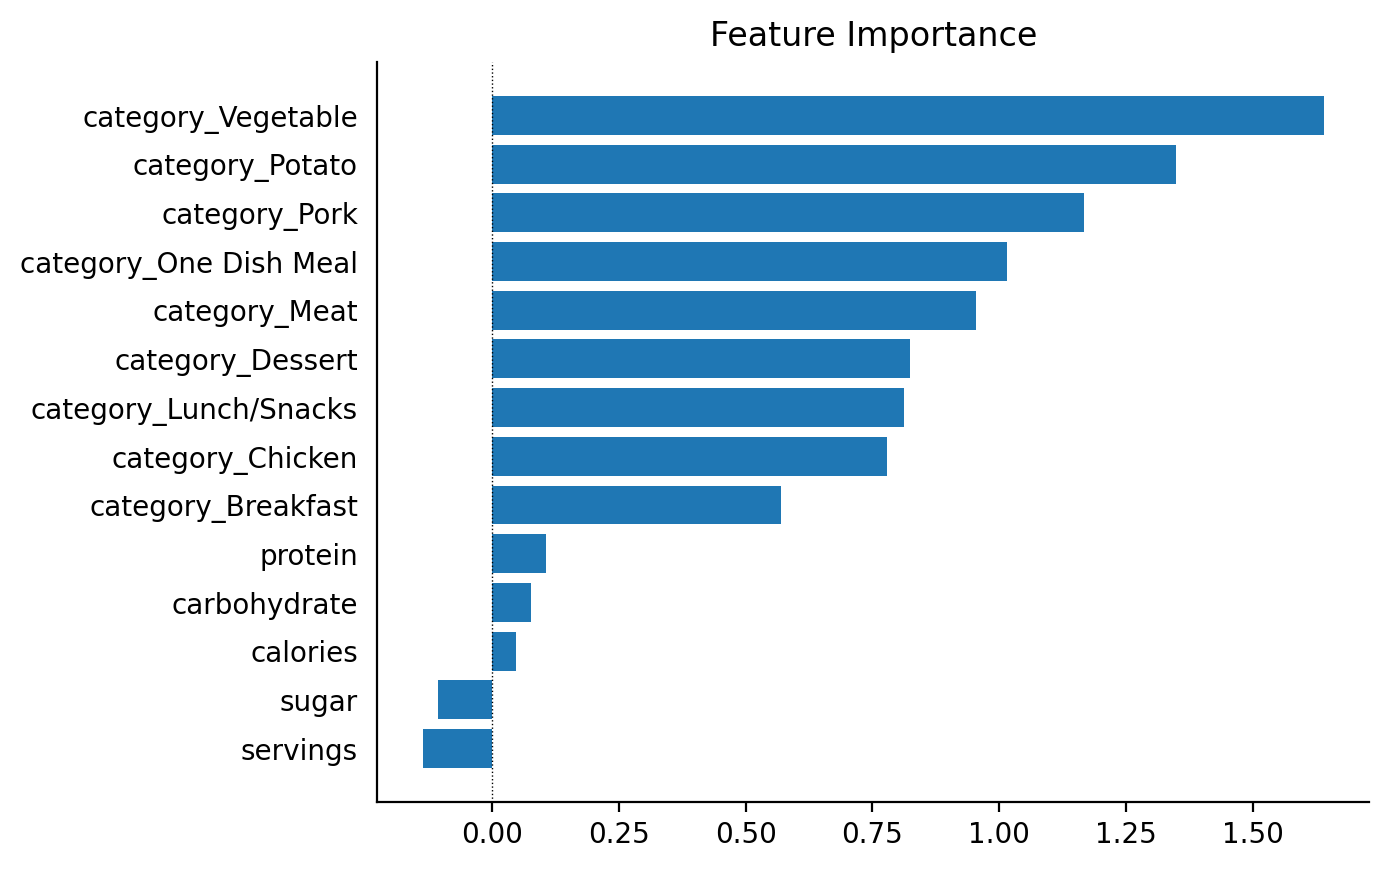

In [18]:
def model_lr(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    model = Pipeline([('scaler', StandardScaler()),('classifier', LogisticRegression(random_state=seed))])
    model.fit(X_train, y_train)
    
    importance = model.named_steps['classifier'].coef_[0]
    evaluate_model(model, X_test, y_test)
    plot_ConfusionMatrix(model, X_test, y_test)
    plot_FeatureImportance(importance, X.columns)
    
model_lr(X, y)

**Model 3: Decision Tree Classifier (fine-tuned):**

Evaluation of DecisionTreeClassifier (fine-tuned) model:
- Best Parameters:
  . criterion: entropy
  . max_depth: None
  . min_samples_leaf: 8
  . min_samples_split: 2
  . splitter: random

- Model Percision is 0.84
- Model Accuracy is 0.74
- Model F1-score is 0.78


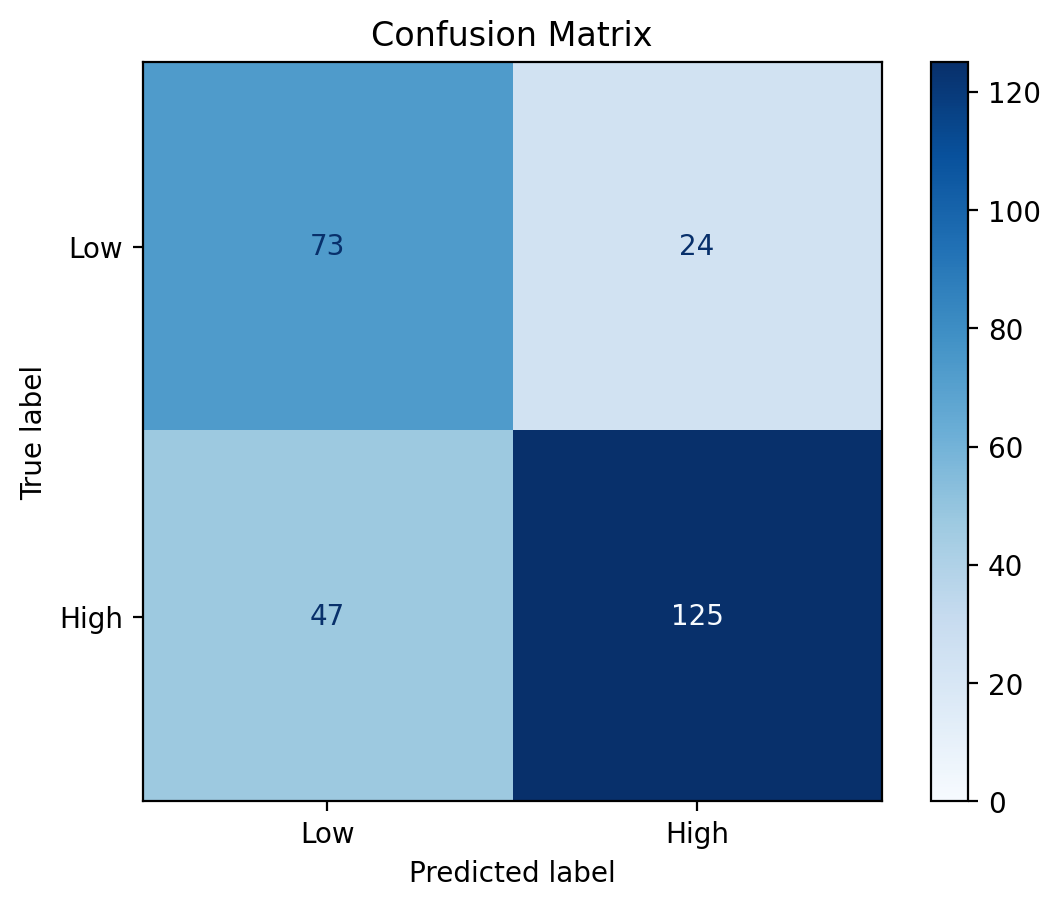

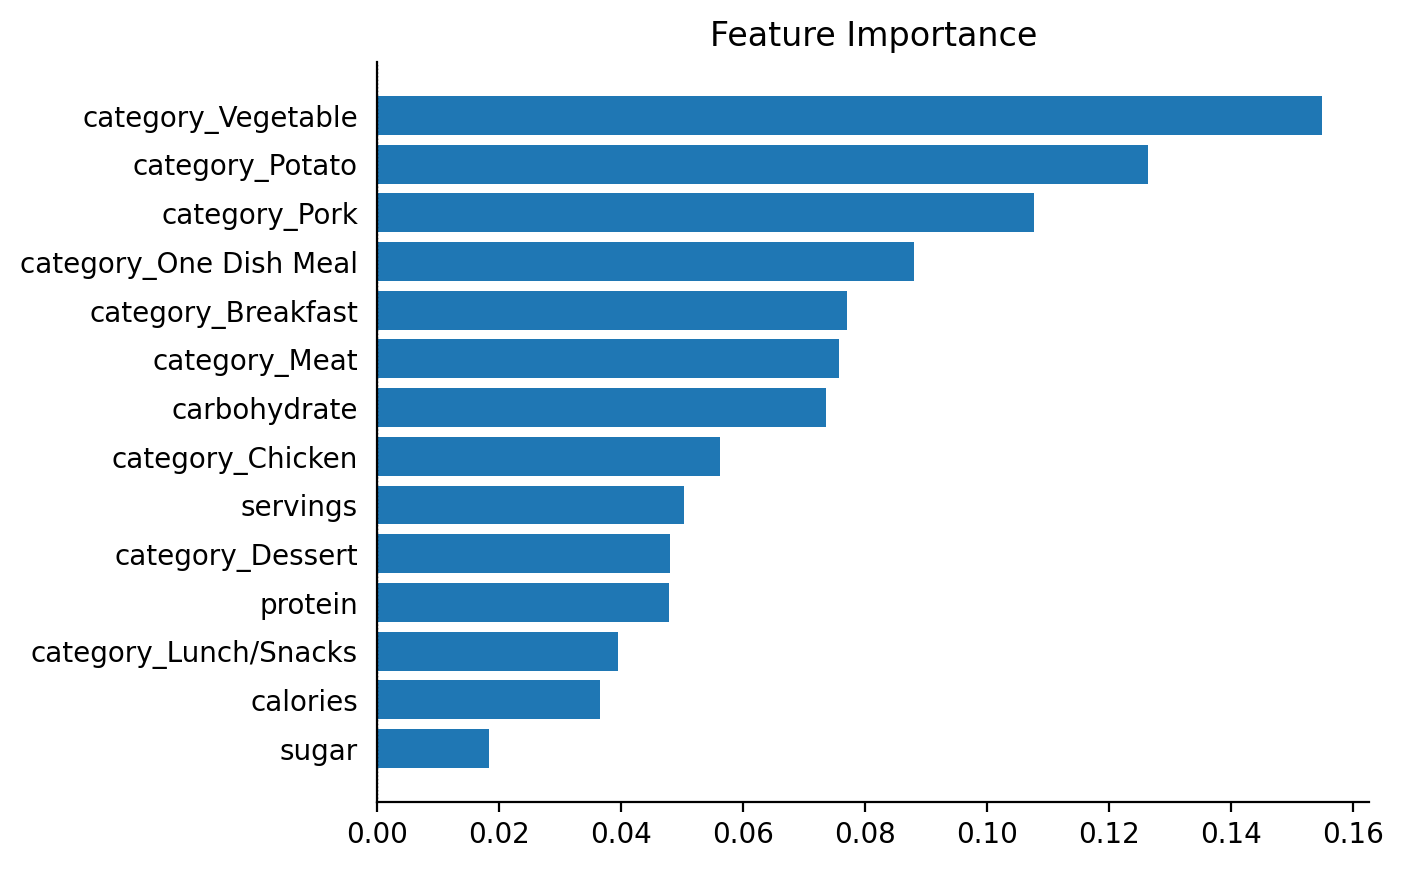

In [19]:
def model_dtc_tuning(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    param_grid = {
        "classifier__criterion": [ "entropy"],  # Use entropy criterion as the dataset has mainly numerical features
        "classifier__max_depth": [None, 5, 10, 20, 50],
        "classifier__min_samples_split": [2, 5, 10, 20],
        "classifier__min_samples_leaf": [1, 2, 4, 8],
        "classifier__splitter": ["best", "random"],
    }

    pipeline = Pipeline([('scaler', StandardScaler()),('classifier', DecisionTreeClassifier(random_state=seed))])
    model = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5)
    model.fit(X_train, y_train)

    importance = model.best_estimator_.named_steps['classifier'].feature_importances_
    evaluate_model(model, X_test, y_test)
    plot_ConfusionMatrix(model, X_test, y_test)
    plot_FeatureImportance(importance, X.columns)

model_dtc_tuning(X, y)

**Model 4: Logistic Regression (fine-tuned):**

Evaluation of LogisticRegression (fine-tuned) model:
- Best Parameters:
  . C: 10.0
  . fit_intercept: True
  . penalty: l1
  . solver: liblinear

- Model Percision is 0.87
- Model Accuracy is 0.80
- Model F1-score is 0.83


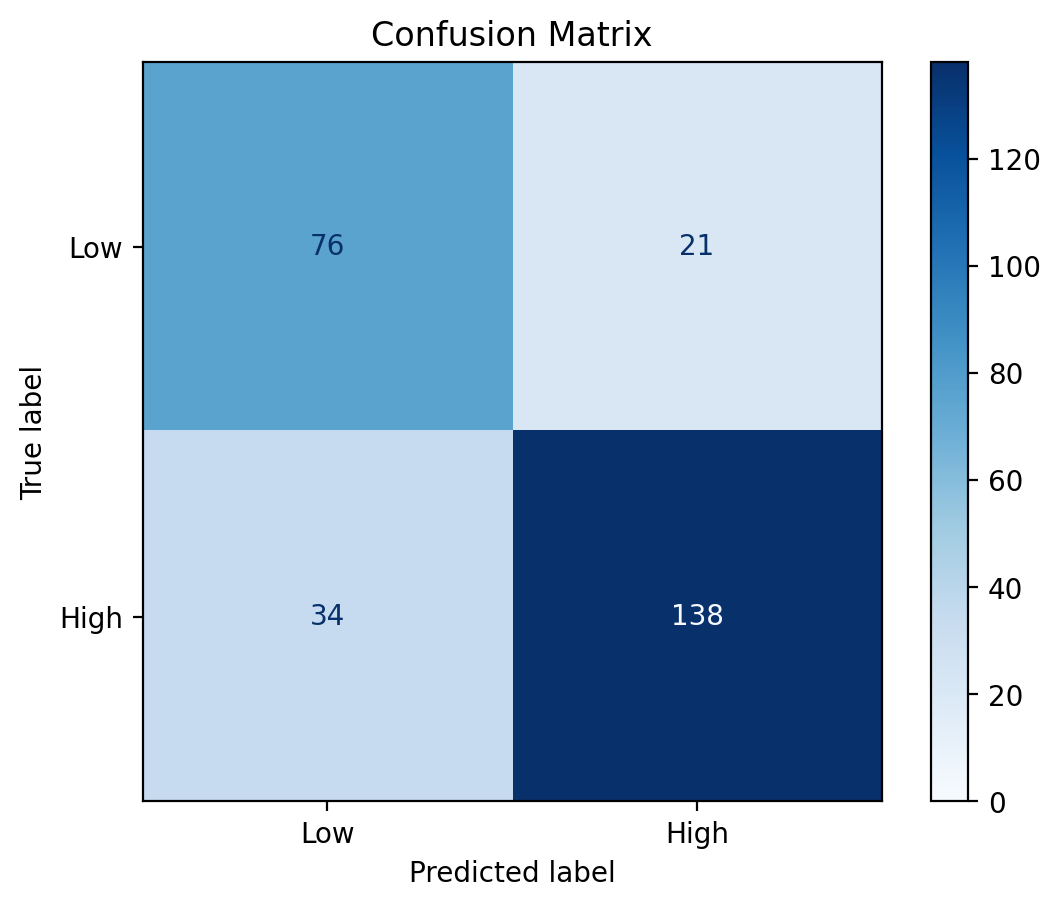

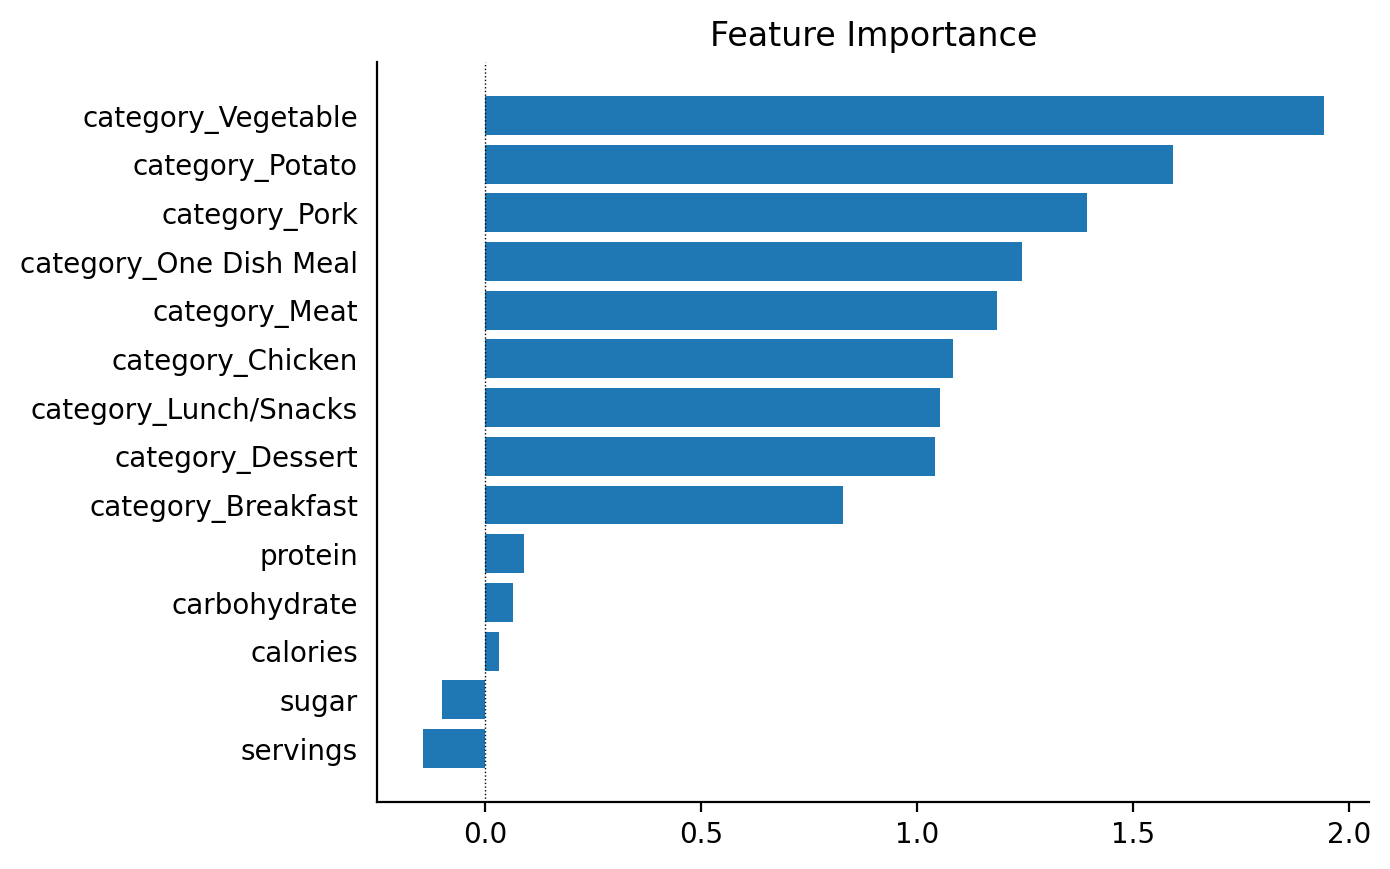

In [20]:
def model_lr_tuning(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    param_grid = {
        "classifier__penalty": ['l1'], # Use L1 penalty because only a subset of features is truly important
        "classifier__solver": ['liblinear'], # Use liblinear solver, which works well with L1 penalty on small datasets
        "classifier__C": np.logspace(-3, 2, 6),  # Use smaller C values since L1 penalty and liblinear solver are used
        "classifier__fit_intercept": [True, False],
    }

    pipeline = Pipeline([('scaler', StandardScaler()),('classifier', LogisticRegression(random_state=seed))])
    model = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5)
    model.fit(X_train, y_train)

    importance = model.best_estimator_.named_steps['classifier'].coef_[0]
    evaluate_model(model, X_test, y_test)
    plot_ConfusionMatrix(model, X_test, y_test)
    plot_FeatureImportance(importance, X.columns)

model_lr_tuning(X, y)

<a id='evaluation'></a>
# 5. Model Evaluation

- After completing the development phase, we will proceed to evaluate the models in a comparative manner.

In [21]:
models_evaluation.sort_values(by='Precision', ascending=False)

Model  Precision  Accuracy  F1 Score
3      LogisticRegression (fine-tuned)   0.867925  0.795539  0.833837
1           LogisticRegression (basic)   0.867089  0.791822  0.830303
2  DecisionTreeClassifier (fine-tuned)   0.838926  0.736059  0.778816
0       DecisionTreeClassifier (basic)   0.775641  0.680297  0.737805

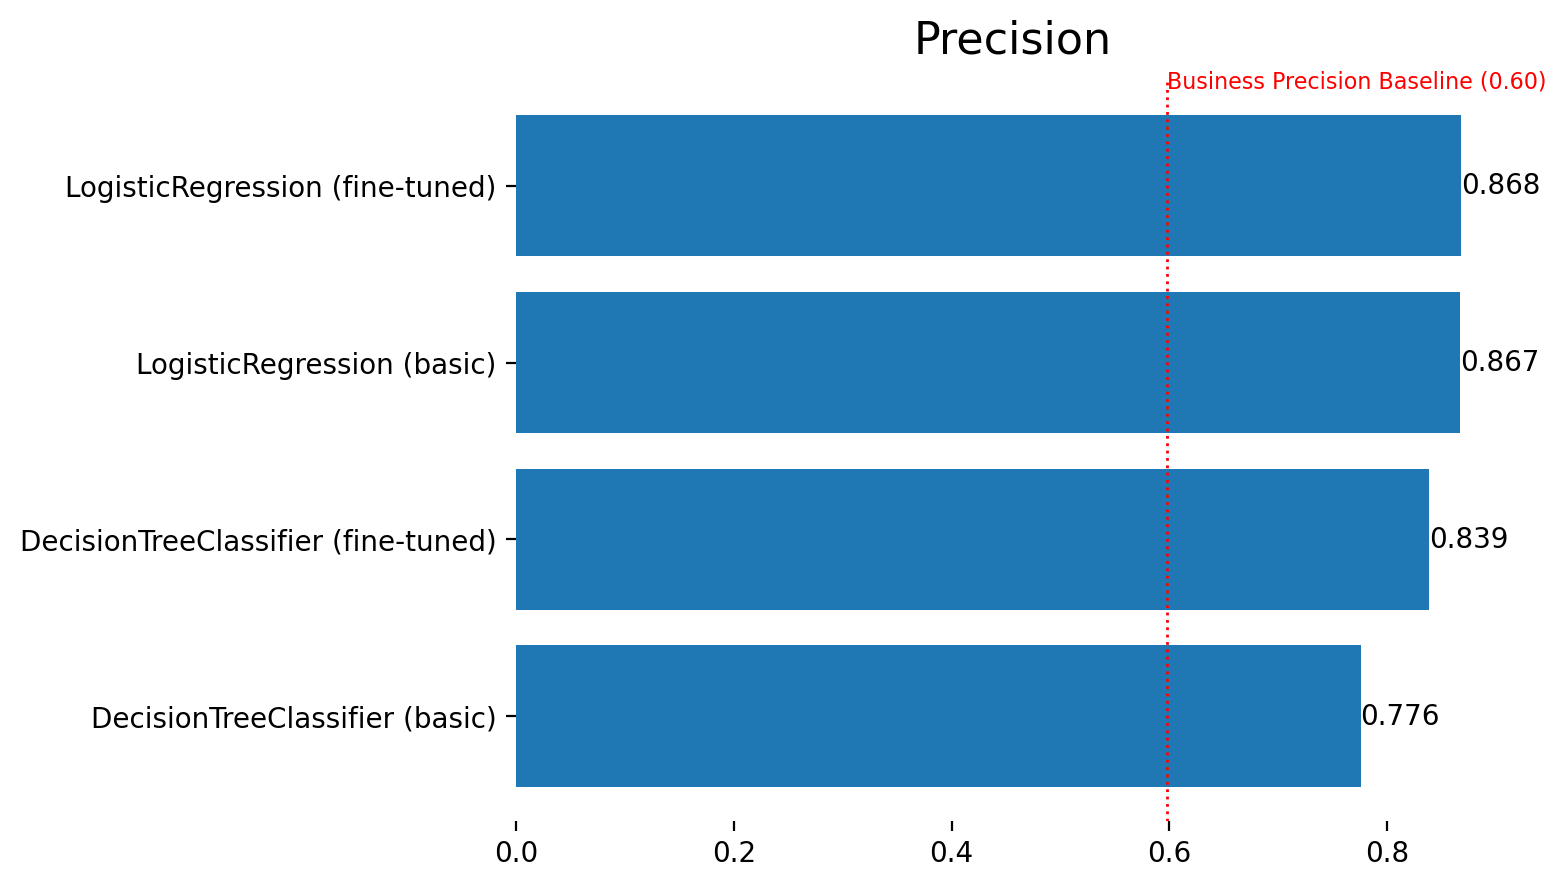

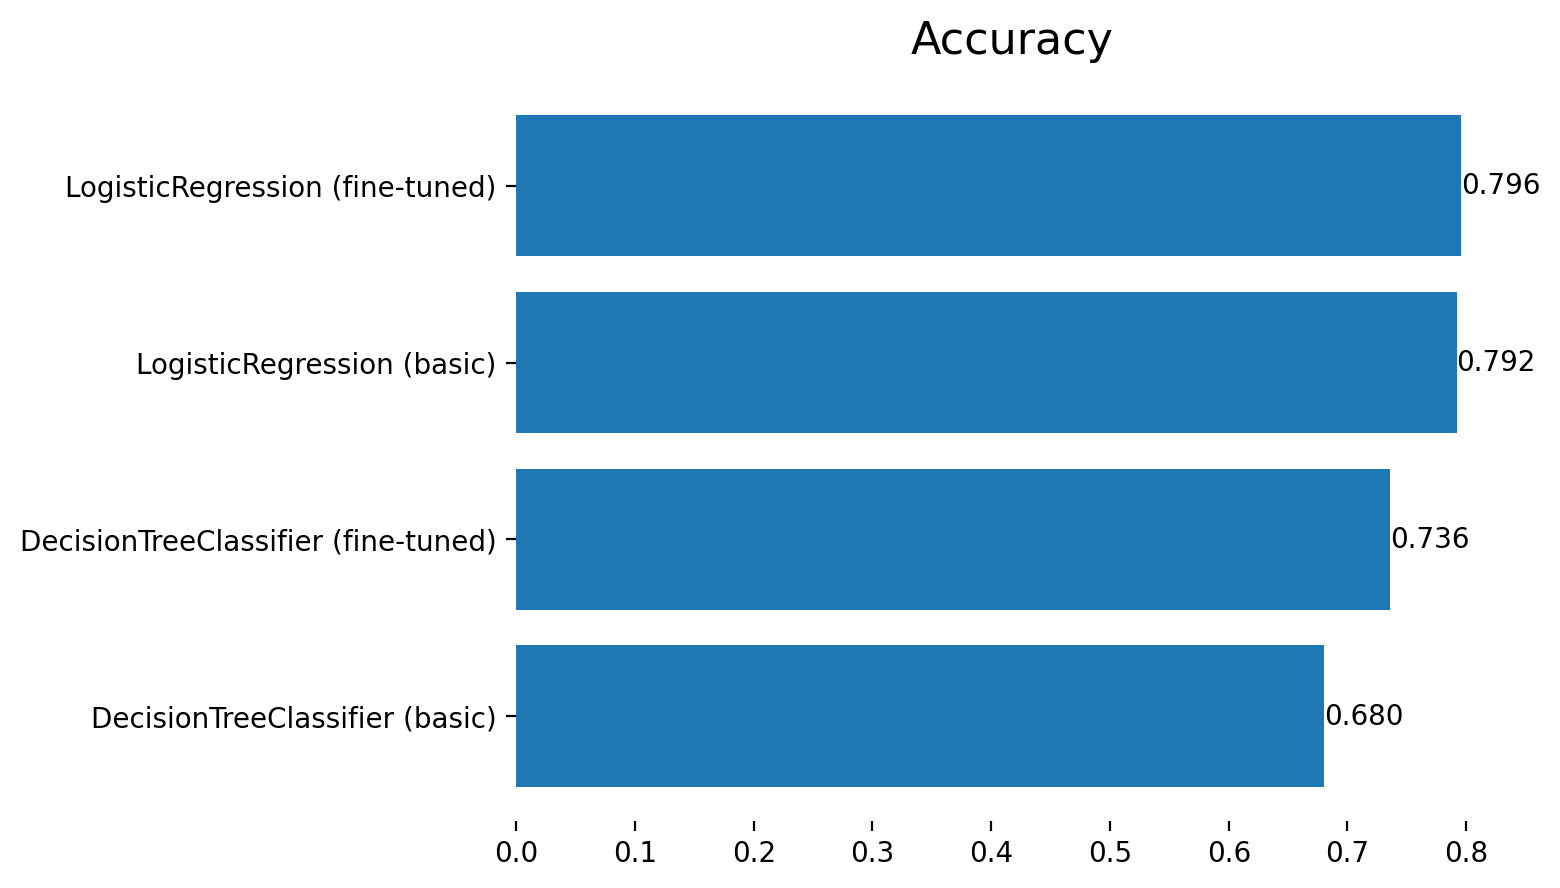

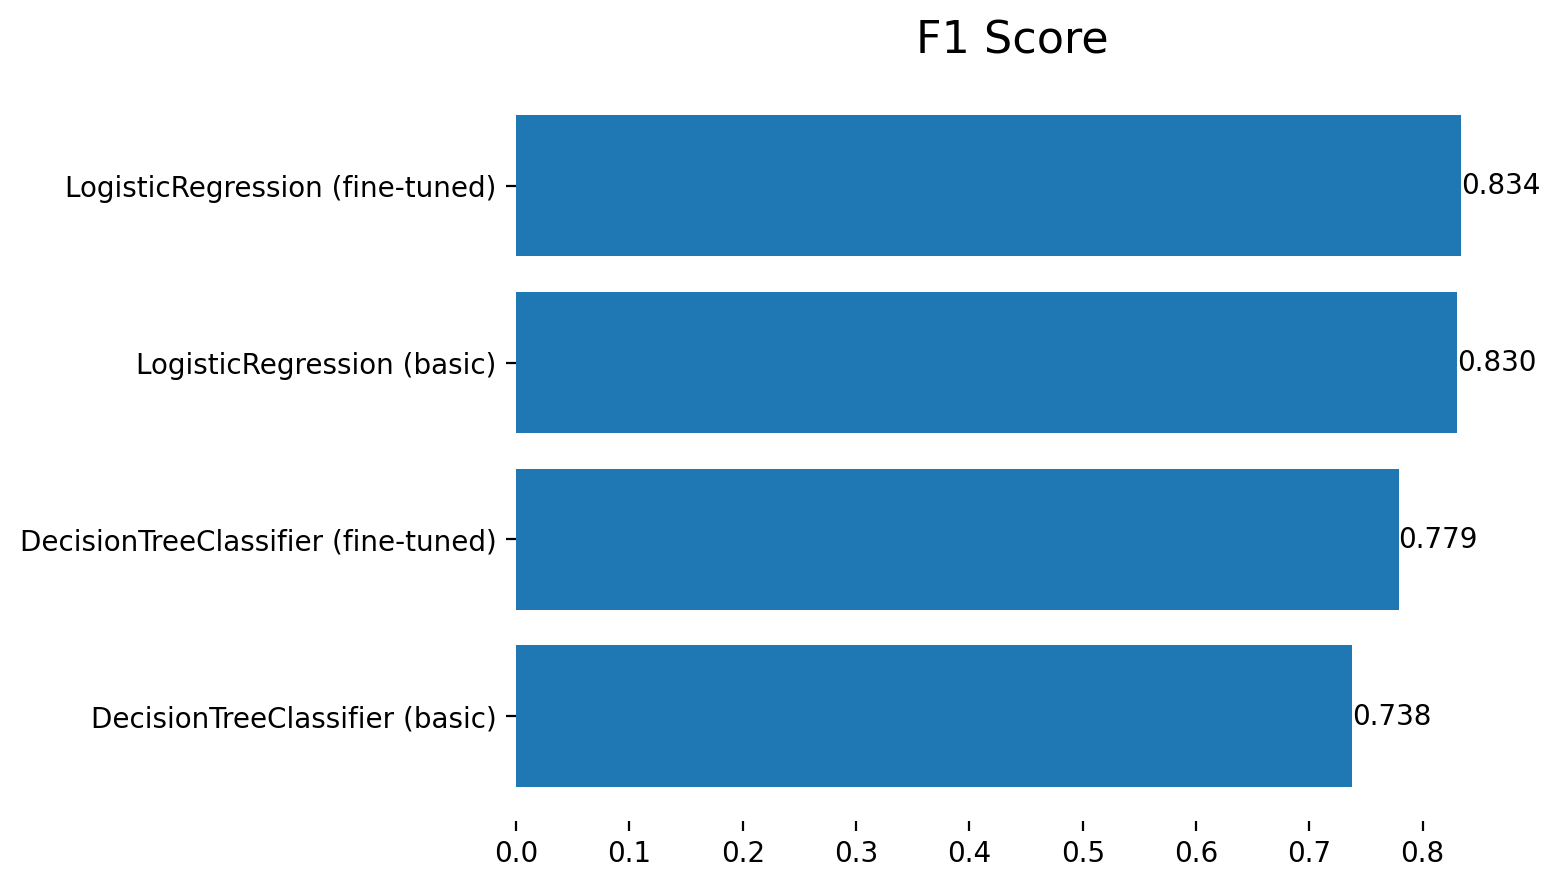

In [22]:
def plot_models_evaluation(df_eval, metric):
    df_eval_sorted = df_eval.sort_values(by=metric)

    plt.barh(df_eval_sorted['Model'], df_eval_sorted[metric])
    plt.title(metric, pad=10, fontsize=16)
    plt.xlabel(None)
    plt.gca().spines[:].set_visible(False)
    for p in plt.gca().containers: plt.gca().bar_label(p, fmt='%.3f')

    # Add specific annotations if the metric is 'Precision' to compare it with business precision
    if col == 'Precision':
        plt.axvline(business_precision, color='red', linewidth=1, linestyle=':')
        plt.text(business_precision, plt.gca().get_ylim()[1],
                 f'Business Precision Baseline ({business_precision:.2f})', ha='left', va='center', color='red', fontsize=8)

    plt.show()

# Get a list of metric columns and plot the evaluation for it 
metric_cols = [col for col in models_evaluation if col != 'Model']
for col in metric_cols:
    plot_models_evaluation(models_evaluation, col)

<a id='business'></a>
# 6. Business Metrics

- **Business goal:**
    * Predict which recipes will lead to high traffic, at least 80% correct.
    * Increase website traffic to boost subscriptions and drive higher profits.


- **KPI:**
    * **Precision:** The ratio of true positive values to all positive values
    * In other words, the rate of recipes that generate high traffic compared to those expected to increase traffic.


- **Method:**
    * Initially, all recipes were assumed to generate high traffic from a business standpoint. However, only 60% of those predictions were accurate.
    * To address this, a model is developed to determine the likelihood of a recipe generating high traffic.
    * Ensuring correct predictions (avoiding false positives) is crucial, as **having recipes on the website that decrease traffic would negatively impact the Tasty Bytes's profits**.


- **Model:**
    * Two models were developed: a Decision Tree Model and a Logistic Regression model.
    * The Decision Tree Model achieved a precision of 0.83 after tuning, while the Logistic Regression model performed even better, reaching a **precision of 0.86**.
    * Compared to the baseline precision of 0.6, the Logistic Regression model represents a significant **43% improvement**.

<a id='recommendations'></a>
# 7. Recommendations

- **Recommendations according to the analysis:**
    - To achieve the business goal of increasing website traffic and boosting subscriptions to drive higher profits by optimizing recipe selection, I recommend implementing the Logistic Regression model developed to determine the likelihood of a recipe generating high traffic. This model has shown promising results and achieved a precision of 0.86, representing a significant 43% improvement compared to the baseline precision of 0.6.
<br><br>
    - In addition, through exploratory analysis plots and feature importance analysis on our models, we have discovered that certain features hold significant influence over traffic, especially when there is high volume. By prioritizing these features, we can generally boost traffic levels. The key features identified are:
      1. Vegetable category
      2. Pork category
      3. Potato category
<br><br>
    - It is crucial to prioritize correct predictions and avoid false positives, as having recipes on the website that decrease traffic would negatively impact Tasty Bytes's profits. By adopting the Logistic Regression model, the company can optimize the selection of recipes and improve the chances of increasing website traffic and driving higher profits.
<br><br>
    - By leveraging the insights provided by the Logistic Regression model, Tasty Bytes can make informed decisions about recipe selection, increase website traffic, and ultimately drive higher profits.
<br><br><br>
- **Additional recommendations:**
    - To enhance the model predictions, it is recommended to expand the dataset by incorporating additional features of the recipes. These features could include information such as "Time to Make", "Cost per Serving", and "Ingredients". By considering these factors, the model's predictions can be further improved.
<br><br>
    - Regular updates and retraining of the model using fresh data should be carried out to ensure its continued effectiveness over time. Ongoing monitoring and evaluation of the model's performance will also be necessary to identify areas for improvement and make necessary adjustments as needed.

# <font color='red'>Thank You!</font>